# README - Controllers for Traffic Regulation in COCO City - Final Project

This repository implements and analyzes three different traffic controllers designed for vehicle density regulation in the COCO City environment. The goal is to optimize traffic flow and avoid gridlock, particularly in the central region, which becomes highly congested toward the end of the simulation without a proper control strategy.

The three controllers included are:

- A **Model-Based MPC** controller, using explicit system models provided by COCO city experts.
- A **Data-Driven DeePC** controller, using historical data for prediction.
- A **Q-Learning** controller, using tabular reinforcement learning.

Each controller is described below with implementation details, tunable parameters, and tuning guidelines.

Further implementation and tuning details are provided as in-line comments within the code, directly alongside each relevant variable and function.

All the visual material used in the presentation slides (plots, metrics, and traffic heatmaps) is automatically generated by the code below.
To include GIF animations, set the parameter generate_gif = True. By default, it is set to False to reduce execution time, as GIF generation is computationally intensive.

---

## 1. Model-Based Controller: MPC

### Implementation

The Model Predictive Controller (MPC) solves an optimization problem at each simulation step based on the linearized discrete-time system:

    ρ(k+1) = A ρ(k) + B v(k) + C q(k) + d

Where:
- ρ(k): state vector (region densities)
- v(k): control input vector (speed limit factors)
- q(k): demand forecast
- A, B, C, d: linearized model matrices

A prediction horizon of N steps is considered. At each timestep, only the first control input is applied.
The cost function includes:
- Density tracking cost to regulate flow and prevent congestion
- Optional control effort penalty to smooth inputs
- Slack variable penalty for soft constraint enforcement

The lifted dynamics use block matrices (Ā, B̄, C̄), and constraints ensure realistic traffic behavior.

### Tunable Parameters and Tuning Strategy

Below are the parameters, their purposes, and how they were tuned:

- `N`: Prediction horizon  
  → Chosen to balance lookahead and computation. Recommended values: 10-20. Larger N improves anticipation, but increases solver load.

- `Q_weight`: Weight on density tracking error  
  → Set high to prioritize maintaining target densities. Adaptive weights are used (see `q_diag_factor`) to penalize regions exceeding capacity.

- `R_weight`: Weight on control effort  
  → Set low (~0.01–0.1) to avoid overly conservative control. Prioritizes performance and responsiveness over smoothness.

- `slack_penalty_weight`: Penalty on slack variables  
  → Increased (e.g. 1200) to strictly discourage constraint violations. Helps enforce the upper bound on predicted densities.

- `r_full_factor`: Scaling factor for the reference density in central region  
  → Lowered (e.g. 0.8–0.9) to make the controller proactively reduce central congestion.

- `q_diag_factor`: Adaptive scaling of Q when regions exceed target density  
  → Dynamically increases penalties on over-congested regions. Helps the controller act more aggressively where needed.

- `max_density_factor`: Sets the soft upper limit on predicted densities  
  → Slightly above nominal capacity (e.g. 1.1–1.2 × target). Used with slack variables to allow soft constraint violation with penalty.

### Tuning Notes and Recommendations

- Increase `slack_penalty_weight` to discourage density violations, while preserving feasibility by allowing soft constraints.
- Use a smaller `r_full_factor` in central regions to anticipate future congestion.
- Adjust `q_diag_factor` to increase Q adaptively for regions exceeding target densities.
- Keep `R_weight` small to allow flexible, reactive control and avoid slowing down response.
- Choose `N` based on solver capabilities; longer horizons improve long-term regulation.
- Set `max_density_factor` close to physical constraints but allow slack for feasibility.
- Re-linearize system matrices (A, B, C, d) at each timestep to maintain model accuracy in dynamic traffic conditions.

All parameter choices were motivated by empirical tuning through simulation, observing flow stability, constraint satisfaction, and avoidance of gridlock.

---

## 2. Data-Driven Controller: DeePC

### Implementation

The Data-enabled Predictive Control (DeePC) algorithm replaces the need for a model by using input/output trajectory data directly. It builds Hankel matrices from historical data:

- `H_up`, `H_yp`: past input/output trajectories
- `H_uf`, `H_yf`: future input/output trajectories

The optimization finds a vector `g` such that:

    u = H_uf @ g
    y = H_yf @ g

Subject to:
- **Consistency constraints**: ensure that `g` matches the current trajectory (`H_up @ g = u_past`, `H_yp @ g = y_past`)
- **Feasibility constraints**: bounds on predicted control inputs and state densities
- **Slack variable**: allows soft constraint violation on maximum density

The cost function includes:
- Tracking error to a fixed reference density (optimal density)
- Optional control effort penalty to smooth inputs
- Slack variable penalty for constraint violations

### Tunable Parameters and Tuning Strategy

Below are the main tunable parameters, their purpose, and how they were tuned:

- `ρ`: Past horizon length (e.g. 10)  
  → Defines how much past data is used for trajectory consistency. Chosen empirically around 10–15 for balance between memory and noise sensitivity.

- `K`: Prediction horizon (e.g. 10)  
  → Number of future steps to optimize. As in the MPC, it is chosen to balance lookahead and computation.

- `Q_weight`: Tracking weight  
  → Penalizes deviation from the desired (optimal) density. Set relatively high to prioritize congestion avoidance.

- `R_weight`: Control effort weight  
  → Kept low to allow aggressive speed changes when needed.

- `congestion_penalty`: Additional penalty on over-capacity regions  
  → Acts like an adaptive Q. Increased (e.g. 200.0) when a region exceeds its target to enforce faster correction.

- `max_density_factor`: Soft upper bound on densities  
  → Slightly above physical max (e.g. 1.4 × reference) to avoid infeasibility while enforcing realistic behavior.

- `slack_penalty_weight`: Penalty for slack variable  
  → High (e.g. 1000.0) to discourage constraint violations but allow them when strictly necessary.

### Tuning Notes and Recommendations

- Start with `ρ = K = 10` and adjust based on data quality and system reactivity.
- Increase `Q_weight` to prioritize reference tracking and congestion prevention.
- Use `congestion_penalty` to dynamically penalize regions above their capacity.
- Set `R_weight` low if aggressive control is acceptable; increase if smoother inputs are desired.
- Use a high `slack_penalty_weight` to strictly limit density violations while preserving feasibility.
- Choose `max_density_factor` to reflect a realistic soft cap for safety.

This configuration was tuned empirically to ensure that DeePC avoids gridlock, maintains flow, and outperforms the P-controller using only data, without requiring a model or forecast.

---

## 3. Bonus Controller: Q-Learning

### Implementation

This controller implements a tabular Q-Learning algorithm using discretized traffic states and actions. It learns a policy by interacting with the environment and updating Q-values using the Bellman equation:

    Q(s, a) ← (1 - α) Q(s, a) + α [r + γ max_a' Q(s', a')]

Where:
- `s`: current state (discretized traffic density)
- `a`: selected action (speed factor)
- `r`: reward received
- `α`: learning rate
- `γ`: discount factor

The policy follows an ε-greedy strategy to balance exploration and exploitation. States are defined via binned density values across regions, and actions correspond to discrete levels of speed control.

The reward function combines:
- Negative average density (to promote flow)
- Positive change in total density Δρ_total (to reward decongestion)
- Large penalty if central region density exceeds a threshold
- Early bonus for using high-speed inputs in the first simulation phase.

### Tunable Parameters and Tuning Strategy

- `alpha`: Learning rate (e.g. 0.3–0.6)  
  → Controls how quickly Q-values are updated. Higher values lead to faster adaptation but risk instability. Lower values slow learning.

- `gamma`: Discount factor (e.g. 0.95–0.99)  
  → Balances immediate vs. long-term rewards. Higher γ values promote long-term decongestion strategies.

- `epsilon`: Exploration probability (e.g. 0.1–0.2)  
  → Sets how often the agent explores new actions. Use higher ε in early training to improve coverage, then decay gradually if needed.

- `n_actions`: Number of discrete action levels (e.g. 5–7)  
  → More actions allow finer control but increase table size. Choose a small number to keep training efficient.

- `n_bins`: Number of bins for state discretization (e.g. 6–10)  
  → Affects state granularity. Too few bins limit expressiveness; too many make learning unstable or slow.

- `central_threshold`: Density threshold in the central region (e.g. 20)  
  → If exceeded, triggers a large negative reward. Helps prevent gridlock in critical areas.

- `reward_density_weight`: Weight for Δρ_total (e.g. 8.5-9.0)  
  → Encourages the system to reduce overall congestion. Increase to prioritize decongestion speed.

- `input_bonus_horizon`: Number of steps where bonus is active (e.g. 50–70)  
  → Provides an early incentive for early high input to clear initial congestion.

- `input_bonus_weight`: Magnitude of the bonus (e.g. 80–100)  
  → Larger bonuses encourage faster initial speed input. Should be balanced to avoid overly aggressive behavior.

### Tuning Notes and Recommendations

- Start with a higher `epsilon` (e.g. 0.3) and decay it over time to favor exploitation once learning progresses (if needed for longer simulations).
- Set `alpha` based on desired reactivity: ~0.5 for fast adaptation, lower if oscillations occur.
- Choose `n_bins` and `n_actions` to keep the Q-table small and tractable, especially in limited training time.
- Use `central_threshold` to reflect congestion-critical levels in the central region.
- Combine negative mean density and positive Δρ_total to balance local and global performance.
- Apply an early bonus (`input_bonus_weight`) to accelerate learning and prevent late-phase congestion.
- Train over multiple episodes to allow stable convergence.

---

## Summary

All controllers were evaluated under a high-demand simulation scenario, with particular emphasis on managing congestion in the central region.

Performance was compared based on:
- Total number of vehicles served
- Ability to mitigate or avoid congestion
- Average waiting time and travel time
- Responsiveness to gridlock formation

The implementation is fully documented, reproducible, and organized by controller type.  
Further details are available through in-line comments in the codebase.

---


### Setup

In [1]:
%env SUMO_HOME=/usr/share/sumo 
# DO NOT TOUCH THE ABOVE LINE: needed for SUMO, which supports the traffic simulation

import os,sys,json,argparse
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import time

# import necessary modules # src is short for "source code", and is a folder that you are given

# The following package is used to estimate the macroscopic fundamental diagram
from src.tasks.estimate import Estimate # Used to estimate the macroscopic fundamental diagram
from src.simulations.testcontrolsim import test_ControlSim # (helper function, can be ignored)

# The following packages are for simulation and control design
from src.tasks.dsl import DSL # DSL is the class used for Dynamic Speed Limit control which runs a ControlSim simulation with Controller in the loop
from src.controllers.controller import Controller # An abstract class for the controllers implemented which determine the dynamic speed limits
from src.simulations.controlsim import ControlSim # A simulation environment in which we test our controllers

# The following packages are for visualization
from src.visualization.visualization import *
from src.data.comparison import Comparison
from src.data.experiment import Experiment

# Load the parameters of the simulation
taskparams_json = "dep/sumo_files/cocoCity/simparams/cocoCity.json"
with open(taskparams_json,'r') as file:
    taskparams = json.load(file)
mfd_taskparams = "dep/sumo_files/cocoCity/simparams/cocoCity_mfd.json"
with open(mfd_taskparams,'r') as file:
    mfd_taskparams = json.load(file)

env: SUMO_HOME=/usr/share/sumo


In [2]:
# Specify simulations you want to run
run_no_controller = True
run_p_controller = True
run_mpc_controller = True
run_data_driven_controller = True
run_q_learning_controller = True

# Generate GIFs for every simulation
generate_gif = False # default False to reduce running time

### Traffic Inflow Problem

You are a control engineer hired by COCO City to improve the flow of traffic in COCO City during the morning rush hour.

#### COCO City's Traffic Grid

The COCO City traffic grid is divided into 5 regions including the periphery regions (Regions 0 to 3) and the city-center region (Region 4).

The 5 roads leading from the periphery regions to the center region (in black) have Dynamic Speed Limit (DSL) functionality that allows COCO City to adjust the speed limits on those roads in real-time.

<img src="figs/COCOcityImage.png" width="800">

The control levers are the dynamic speed limits (DSLs) of the five roads leading to the center region (the black roads numbered 0-4 in the figure above). Each DSL control lever is a number between 0.5 and 1.5 which multiplies the nominal speed limit of 50 km/h to determine the DSL for the given road.

COCO City has hired you to design an algorithm which takes in 1) the densities of the cars on the road and 2) the forecast of the cars that will spawn in each region in the coming timesteps and determines the DSLs for the five roads leading into the city center.

### COCO City provides you with the following

#### A Simulation of Urban MObility (SUMO) traffic simulator with code to implement their basic controller

SimUlation of Urban Mobility (SUMO) is an open-source traffic simulation package which runs a "microscopic" traffic simulation that allows for control of specific cars, and lights, speed limits. In this project, our code interfaces with the SUMO simulator via DSLs and measures density for each region, the number of vehicles travelled, travel time, CO2 emissions, and a few other metrics.

Each simulation timestep corresponds to 20 seconds of wall-clock time.

When COCO City's controller is running, the code interfaces with SUMO to start and stop simulations and to control road speed limits at each simulation step. The code is object-oriented. "tasks" are abstract classes which support subclasses such as a "DSL" task, which run a DSL-control simulation. When a task is instantiated, the code creates a simulation of the traffic network with details specified in the task parameters/function inputs.

A DSL task creates a simulation object called ControlSim, which contains functionality to run the DSL traffic system simulation while continuously adjusting speed limits on specific roads with control logic that you define. The specifics for how to implement a new controller are given in the "How to implement a controller" section below.


                                                                                                                                                                                                                                                                                                                                                                                   

#### The optimal densities for each region, derived from the Macroscopic Fundamental Diagrams (MFDs)

Research on traffic systems shows that maximum flow is reached at a certain density of cars---when density is too low there are few cars flowing through the network, and when density is too high traffic jams arise, impeding the speed at which vehicles travel. The function mapping density to flow is called the Macroscopic Fundamental Diagram (MFD). The maximum flow occurs at a certain optimal density $\rho^*$. 

COCO City's objective is to maximize the flow of vehicles through the city by adjusting the DSLs up or down. DSLs directly affect the density in a given region, as the change in the number of cars in a given region depends on the speed limits of the roads that enter the region.

The mapping between densities and flows, however, is nonlinear. Thus, it is common in traffic control to track the optimal density for a given region, rather than maximizing flow.

With this in mind, COCO City has run experiments to determine the MFD for their city and gathered the following data for the center region/Region 4 (similar plots are available for regions 0-3). 

<img src="figs/MFD_COCOcity_centerRegion.png" width="600">

From the gathered data, it is evident that the optimal densities are approximately 5.70, 9.83, 10.63, 14.55, and 11.94 for regions 0-4, respectively.

In [3]:
rho_star = np.array([5.70, 9.83, 10.63, 14.55, 11.94])
n_regions = 5

optimal_density = {f"Region {region}": round(rho_star[region],2) for region in range(n_regions)}
print('Optimal Densities:\n', json.dumps(optimal_density, indent=4))

Optimal Densities:
 {
    "Region 0": 5.7,
    "Region 1": 9.83,
    "Region 2": 10.63,
    "Region 3": 14.55,
    "Region 4": 11.94
}


#### Training data gathered from offline traffic simulations with a legacy controller.

COCO City has provided you with training data to support you in developing a data-driven controller. The training data was gathered with a simple P controller which adjusts the DSLs using proportional feedback control to keep the system close to $\rho^*$.

The training data simulation provides, for each timestep,
1) the density of cars in each region, and
2) the number of cars that spawn in each region.

There is also an underlying flow of cars which can be measured (e.g., to build the MFD), but for simplicity the flows are not provided in the training data set (see the MFD section above for an explanation why the density is preferable to flow).

The timeseries for the spawned vehicles for each of the five regions in the training data are:

<img src="figs/spawning_training.png" width="800">

Data Columns:
['Unnamed: 0' 'Speed limit factor for road 0'
 'Speed limit factor for road 1' 'Speed limit factor for road 2'
 'Speed limit factor for road 3' 'Speed limit factor for road 4'
 'Cars Spawning in Region 0' 'Cars Spawning in Region 1'
 'Cars Spawning in Region 2' 'Cars Spawning in Region 3'
 'Cars Spawning in Region 4' 'Density in Region 0' 'Density in Region 1'
 'Density in Region 2' 'Density in Region 3' 'Density in Region 4']


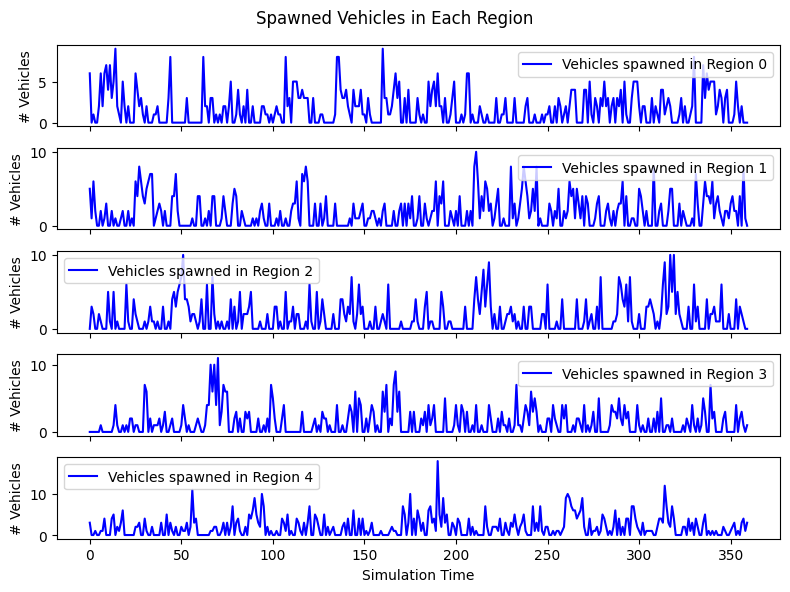

In [4]:
# The pd.read_csv() line below gives io_data, which can be used as data for your data-driven controller
io_data = pd.read_csv(f'./dep/sumo_files/cocoCity/control/edge/io_data.csv')
print(f"Data Columns:\n{io_data.columns.values}") # this line prints the column names of the training data

# # the following code produces the evaluation scenario plot above
spawnedVehicles = np.load('dep/sumo_files/cocoCity/routing/spawning_training.npy')
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for region in range(5):
    axes[region].plot(spawnedVehicles[:,region], color='blue', label = f"Vehicles spawned in Region {region}")
    axes[region].set_ylabel("# Vehicles")
    axes[region].legend()
axes[region].set_xlabel("Simulation Time")

plt.suptitle("Spawned Vehicles in Each Region")
plt.tight_layout()
plt.savefig("spawning_training.png", dpi=300, bbox_inches='tight')
plt.show()


#### Linear traffic model

COCO City has also provided you with a linear state-space approximation of their system dynamics, to support you in developing a model-based controller.

The linear state space linearization, developed internally, approximates how the DSL ratios ($v$) and the spawned vehicles ($q$) relate to the densities in each region ($\rho$):
$$
\boldsymbol{\rho}(k+1) = A \boldsymbol{\rho}(k) + B \boldsymbol{v}(k) + C \boldsymbol{q}(k) + d
$$

The linear system is described by the matrices $A$, $B$, $C$, and the vector $d$ which accounts for the offset that arises when linearizing the nonlinear dynamics. The following code demonstrates how to get $A$, $B$, $C$, and $d$ using the code provided to you by COCO City. The nominal linearization point is $\boldsymbol{v}^* = 1$ (corresponding to 50 km/h) and $\boldsymbol{\rho}^*$ corresponding to the optimal densities for each region according to the MFD. (The original dynamics are linear in $q$, and thus a linearization point $q^*$ is not needed.)

COCO City has provided you with a detailed explanation of the linearized dynamics, which can be found in the accompanying COCOcity_LinearizationNotes pdf. It is not critical that you understand the dynamics linearization, but the file is there if you would like to. If you do investigate the linearization, you will find that COCO City has made of approximations to make the linearization tractable. Thus, while the linearization may be useful for model-based controllers, it is not a faithful representation of the system.

In [5]:
# The code below povides the linear traffic model parameters A, B, C, and d

dsl_task = DSL(taskparams, test_ControlSim) 
rho_star = np.array([5.70, 9.83, 10.63, 14.55, 11.94])
v_target = np.ones(5)
sim_period = 20 # sampling time (fixed)
model = dsl_task.simulation.get_model()
A, B, C, d = model.linearize(sim_period, rho_star, v_target)

print("Matrix A:")
display(A)
print("Matrix B:")
display(B)
print("Matrix C:")
display(C)
print("Vector d:")
display(d)

Matrix A:


array([[0.96144546, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.92674637, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.96144546, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.96144546, 0.        ],
       [0.03052235, 0.06104469, 0.03052235, 0.03052235, 0.9       ]])

Matrix B:


array([[ 0.        , -0.2197609 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.36004161, -0.36004161,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.4098348 ],
       [-0.56096861,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.44410015,  0.17397738,  0.30003467,  0.30003467,  0.32445255]])

Matrix C:


array([[0.00077109, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00073254, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00077109, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00077109, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00061045]])

Vector d:


array([ 0.2197609 ,  0.72008322,  0.4098348 ,  0.56096861, -1.54259943])

#### Evaluation Scenario

COCO City has provided you with the following timeseries of vehicle spawning in each region to evaluate different controllers. Without control, the evaluation scenario leads to gridlock.

<img src="figs/spawning_eval.png" width="800">

For the evaluation, you are given a perfect prediction of the vehicles that will spawn in the future (how the prediction is provided to you is explained below). While it is not realistic to have a perfect forecast (there is always error in predictions), COCO City finds this imperfection acceptable for a proof-of-concept. 

In [6]:
# the following code produces the evaluation scenario plot above
#spawnedVehicles = np.load('dep/sumo_files/cocoCity/routing/spawning_evaluation.npy')
#fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
#for region in range(5):
#    axes[region].plot(spawnedVehicles[:,region], color='blue', label = f"Vehicles spawned in Region {region}")
#    axes[region].set_ylabel("# Vehicles")
#    axes[region].legend()
#axes[region].set_xlabel("Simulation Time")

#plt.suptitle("Spawned Vehicles in Each Region")
#plt.tight_layout()
#plt.show()


#### How to implement a controller

As stated in the SUMO background section above, a DSL task creates a simulation object called ControlSim, which contains functionality to run the DSL traffic system simulation while continuously adjusting speed limits on specific roads with control logic that you define. A DSL task takes a ControlSim object, which you define, as an input and runs a simulation when dsl_task.runtask() is called.

The ControlSim object you define (e.g., ControlSim below) is a wrapper for the ControlSim abstract class (defined by/for the SUMO code) and must include a compute_input() function (see below for an example). The compute_input() function takes in a number of inputs (see below) as well as a controller object, which you also define. 

The Controller object you define is a wrapper for the Controller abstract class (a *different* abstract class, also defined by/for the SUMO code) and must include a get_next_input() function (see below for an example). The get_next_input() function is where you will implement the computational controllers that you develop to improve upon COCO City's controller.

To evaluate a given controller, defined for a DSL task when the task in instantiated (see below), the following command is used:
`experiment = dsl_task.runtask()`.
COCO City has built runtask() with the evaluation data set which they use to determine the quality of a given controller. This evaluation data set is similar to the training data provided above, but slightly different and more challenging. Specifically, the training data set leads to gridlock when no control is used. See the demonstration below. Note, the evaluation data should not be used to train a new controller. Rather, the training data (above) should be used.

The code below shows how noControl, which applies the nominal input (DSL of 1), performs on the evaluation set. Notice that at the end of the simulation, the central region is gridlocked and no flow occurs.

In [7]:
class noControl_controller(Controller):
    def __init__(self,actuators,params = {}) -> None:
        '''Initialize the controller'''
        super().__init__(actuators=actuators, params=params)
        self.name='noControl_controller'
        self.example = params['Example']
        
    def get_next_input(self):
        '''
        [CONTROLLER DESCRIPTION]
        -------------------------------
        Inputs: IMPLEMENT
        Outputs: IMPLEMENT
        '''
        u = np.ones(5) # one input for each DSL
        y = np.zeros(5) # one output prediction for each region
        return u, y 
    
class ControlSim(ControlSim):
    def __init__(self,network,taskparams,actuators,controlparams = {}):
        super().__init__(network=network,taskparams=taskparams,actuators=actuators,controlparams=controlparams)

    def compute_input(self, k, forecast, controller, controller_name, 
                      uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix, m, p, rho_opt, u_min, u_max):
        '''
        Compute the input for the controller.

        This function is called "under the hood" of an Unjam traffic simulation/a dsl_task. Thus, the inputs to compute_input are provided automatically. 
        
        COCO City has set up the code so that the following inputs are provided to compute_input for you:
        - forecast, which provides the forecast of the spawned vehicles to be used for predictive control (though some engineering is required to produce y_future), 
        - uAppliedMatrix and yMeasuredMatrix are the matrices of inputs and outputs filled in over the course of a simulation. They can be used as the lead-in data for a data-driven controller (though some engineering is required).
        - ySingleStepPredMatrix is the matrix of single step predictions ySingleStepPred, filled in over the course of a simulation.
        -------------------------------
        **Inputs:
        k: int, discrete time step (each discrete time step corresponds to 20 seconds of wall-clock time)
        forecast: np.array, forecast of spawned vehicles from all 5 regions (including center region) to the center region
        controller: Controller, controller object, defined separately
        controller_name: str, name of the controller
        uAppliedMatrix: np.array, memory of applied control inputs (zeros for timesteps that have not occurred yet)
        yMeasuredMatrix: np.array, memory of outputs (zeros for timesteps that have not occurred yet)
        ySingleStepPredMatrix: np.array, memory of single-step predicted outputs (zeros for timesteps that have not occurred yet)
        m: int, number of actuators
        p: int, number of outputs (1 per region)
        rho_opt: np.array((5,)), optimal density for each of the 5 regions
        u_min: np.array, minimum control input for each actuator (0.5)
        u_max: np.array, maximum control input for each actuator (1.5)
        -------------------------------
        **Returns:
        uApplied: np.array, control input for each actuator (5 actuators) (automatically put into uAppliedMatrix)
        ySingleStepPred: np.array, predicted density for each region (5 regions) (automatically put into ySingleStepPredMatrix)
        '''
        
        if controller_name == 'noControl_controller':
            uApplied, ySingleStepPred = controller.get_next_input()
        elif controller_name == 'anotherMethod_controller':
            pass # implement controller 
        
        return uApplied, ySingleStepPred
        


#### Defining control parameters

When you instatiate a controller, you pass the controller parameters in the form of a dictionary (see {'Example': 5} below).

These parameters include, for example the control cost and regularization parameters.

The parameters may also include the dynamics matrices for the model-based controller, as well as the data driven predictor (Hankel matrix for DeePC, Transient Predictor for TPC) for data-driven controllers.


In [8]:
# for the no control case, no parameters are needed. Below is just an example of how a parameter could be set.
noControl_control_params = {'Example': 5}

In [9]:
# takes around 30s to run
if run_no_controller:
    dsl_task = DSL(taskparams, ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class

    experiment = dsl_task.runtask(init_from_notebook=True, controller_class=noControl_controller, controller_json=noControl_control_params) 
    # this line will instantiate a SUMO simulation and the specified controller
    # The controller is determined by "controller_class" and the parameters are determined by "controller_json"
    # runtask starts SUMO (the traffic sim)
    # "experiment" is the saved output of the simulation

Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (6ms ~= 166.67*RT, ~176666.67UPS, TraCI: 154ms, vehicles TOT 1635 ACT 1060 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


#### Controller evaluation tools

COCO City has provided you with the `Comparison` package to evaluate the performance of controllers. The `Comparison` package includes 

`plot_density()`, 

`plot_flow()`, 

`plot_input()`, and

`plot_metrics()`, which plots the total CO2 emissions, travel time for all vehicles, waiting time for all vehicles, and the number of vehicles which successfully reached their destination.

Additionally and optionally, you have access to the `Experiment` package to load a previously saved simulation using the function `load(output_dir)`. An example of how this can be used is included below. Note that the default output directory of a simulation (`/out/cocoCity/cocoCity/`) will be overwritten at the next experiment. Therefore, if you wish to use previously saved results you are encouraged to copy the output folder and rename it.

COCO City has also provided you with GIF-generating code to visualize the road congestion/densities over the course of a simulation.

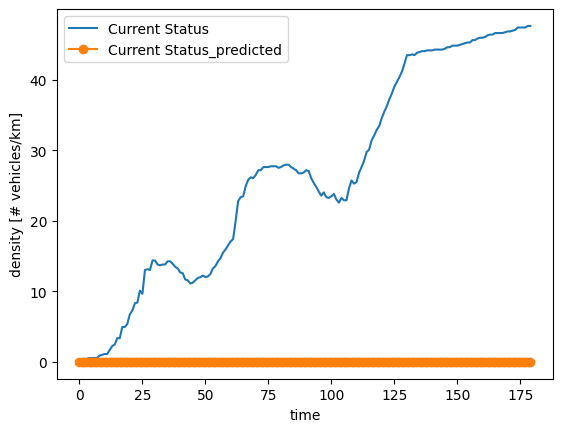

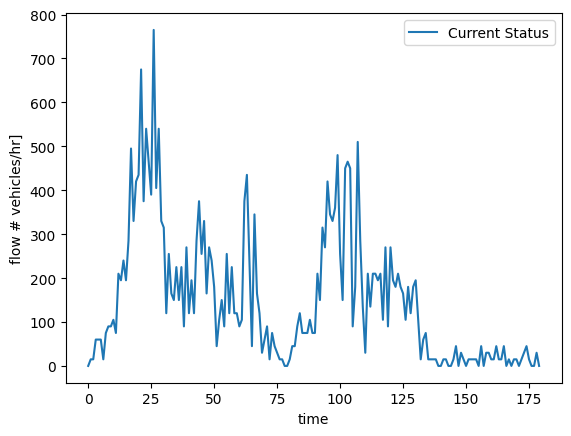

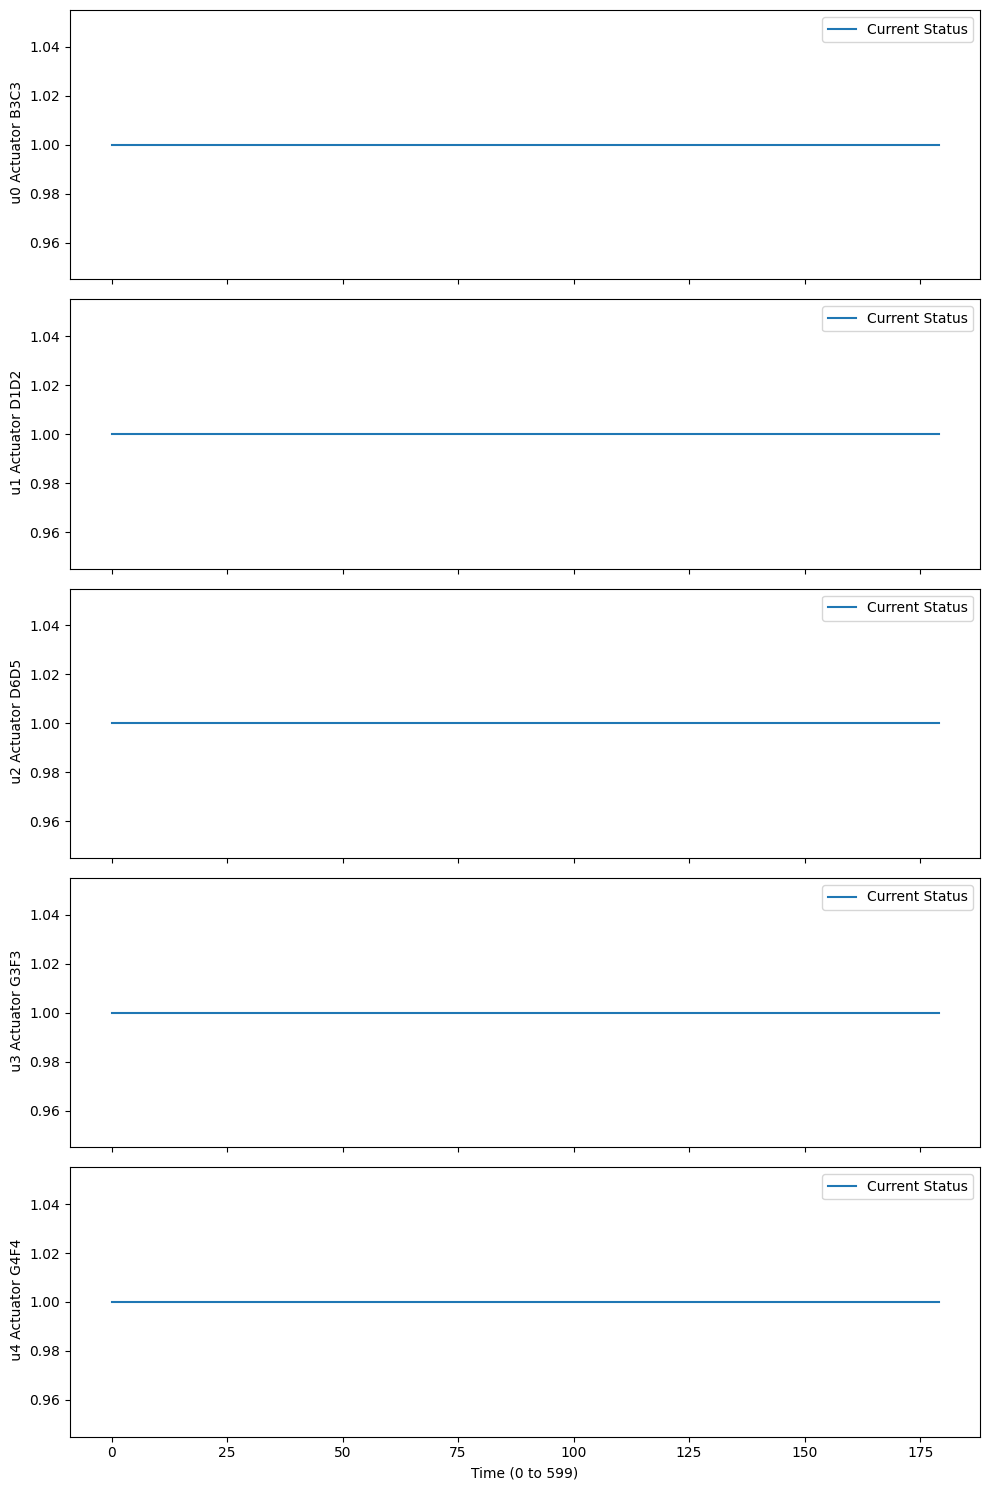

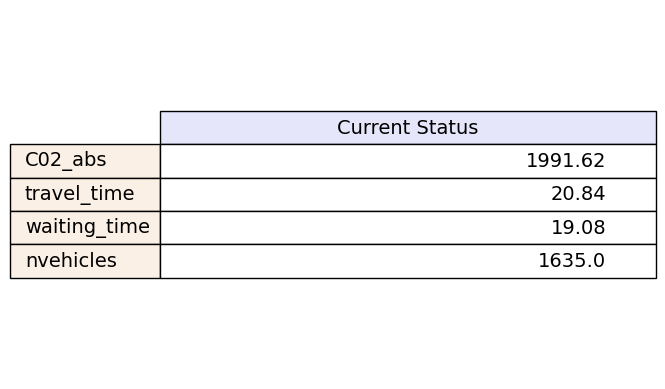

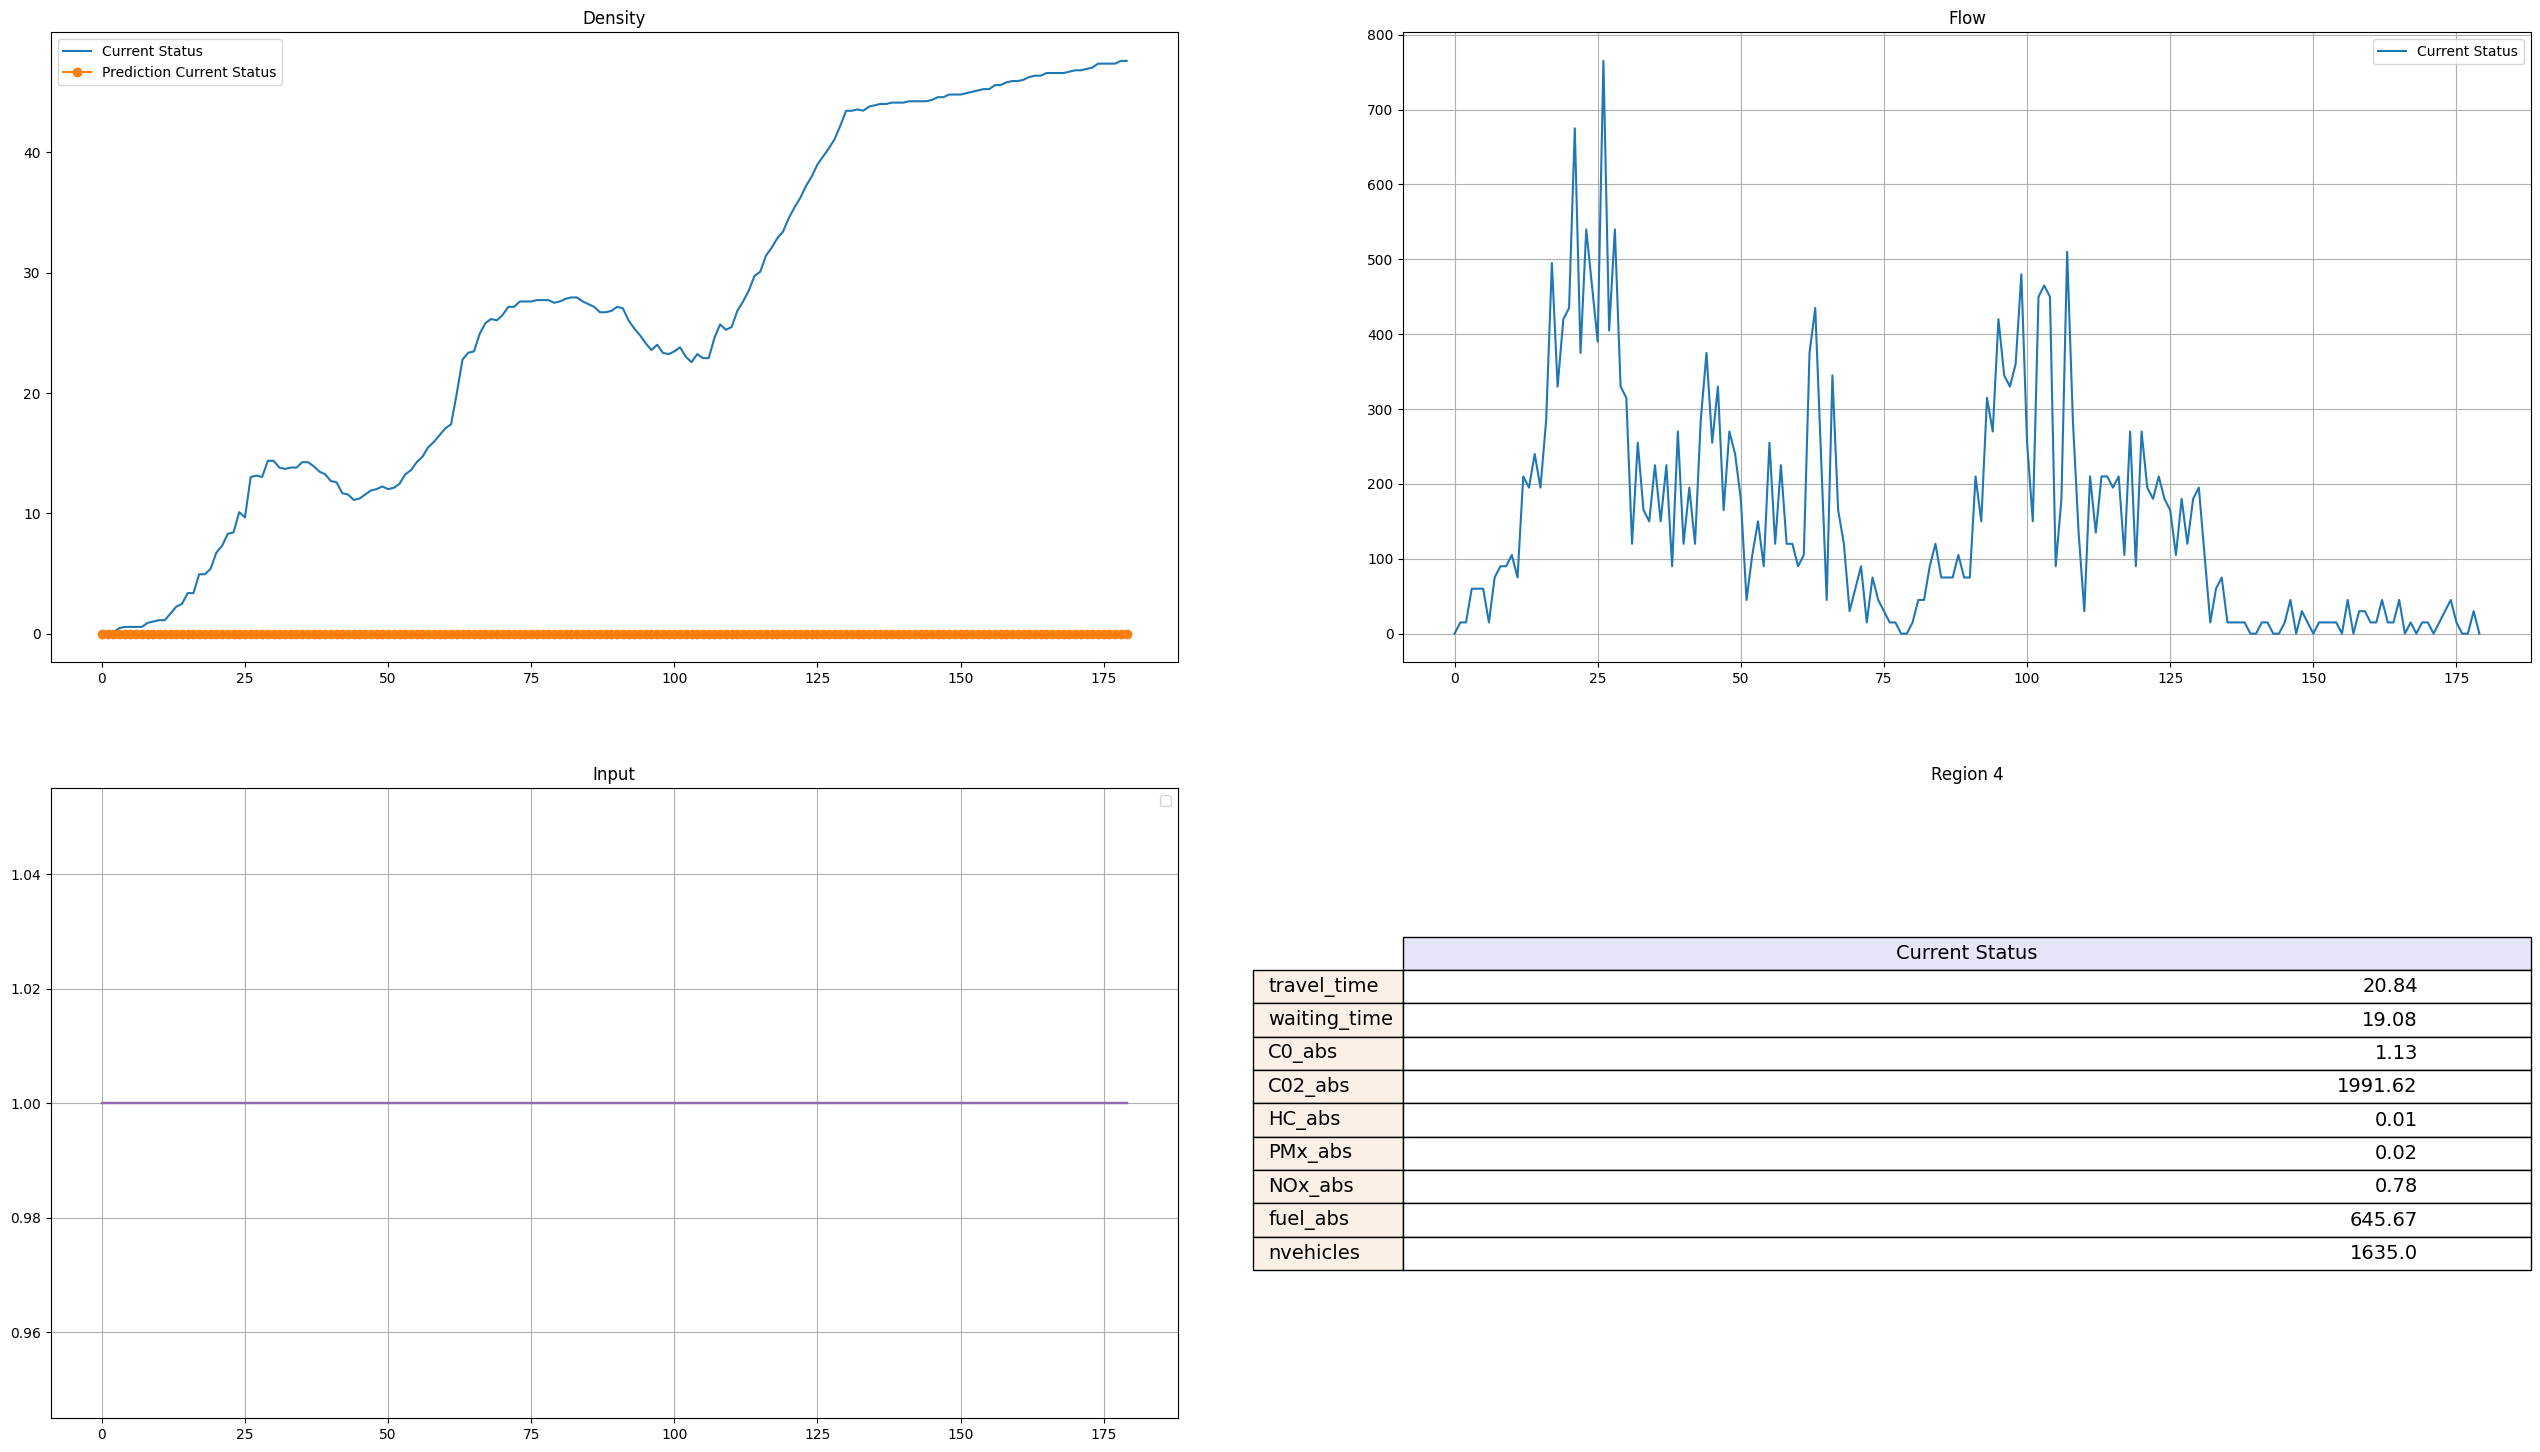

In [10]:
if run_no_controller:
    region = 'Region 4'
    com = Comparison([experiment], ['Current Status'], region=region)
    
    com.plot_density()
    com.plot_flow()
    com.plot_input()
    com.plot_metrics()
    com.plot()

In [11]:
## Alternatively, if you have the saved output_dir, you can also plot the results.
#output_dir = experiment.info['output_path']  # This is where the output of the experiment was saved.
#experiment_saved = Experiment() # instantiate an empty experiment
#experiment_saved.load(output_dir) # Load in the simulation experiment result
#com = Comparison([experiment_saved], ['Current Status (saved)'], region=region)
#com.plot_metrics()

In [12]:
if run_no_controller and generate_gif:
    # GIF Generation
    # [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
    %matplotlib agg 
    
    # This takes around 2 minutes (can be commented out)
    # (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
    output_dir = experiment.info['output_path'] # This is where the output of the experiment was saved.
    output_gif_path = "figs/no_control_demo_heatmap.gif"   # Specify where to save the density git file, can change to your own path
    cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 
    
    # Display saved GIF
    # [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
    %matplotlib inline
    display(Image(url=output_gif_path))
    plot_color_legend(cmap, norm)

#### COCO City's current status: P control

COCO City currently is running a P controller which keeps the density in the center region close to the optimal density by adjusting the DSLs proportionally to the error between the center-region density and the optimal density. The following block diagram describes how $\rho$ feedback loop is used to adjust the DSLs by the COOC City P control.

<img src="figs/COCOcity_pController.png" width="600">

The factor that multiplies 50 km/h for each road is $u = 1 + K_p e$, where $e = \rho_4 - \rho_4^*$. The max $u$ is 1.5, corresponding to 75 km/h, and the minimum speed limit is 0.5, corresponding to 25 km/h. That is, the speed for each DSL is $50 + 50 K_p (\rho_4 - \rho_4^*)$, clipped at 25 and 75 km/h.

The P control is demonstrated below.

Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (7ms ~= 142.86*RT, ~136285.71UPS, TraCI: 128ms, vehicles TOT 1649 ACT 954 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


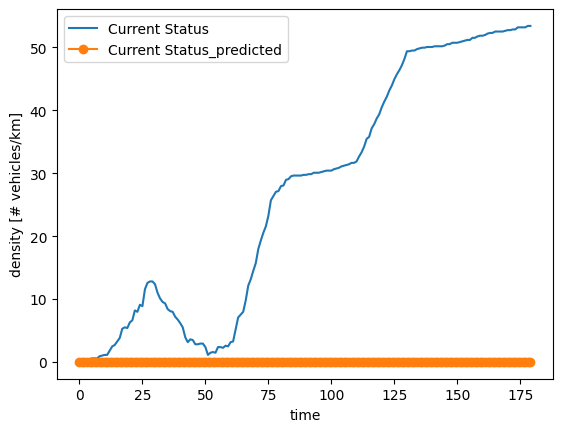

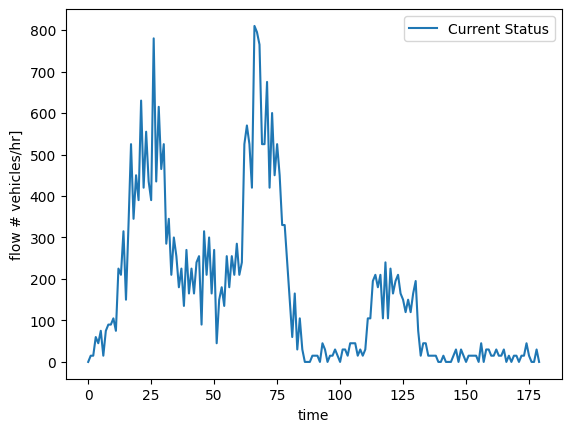

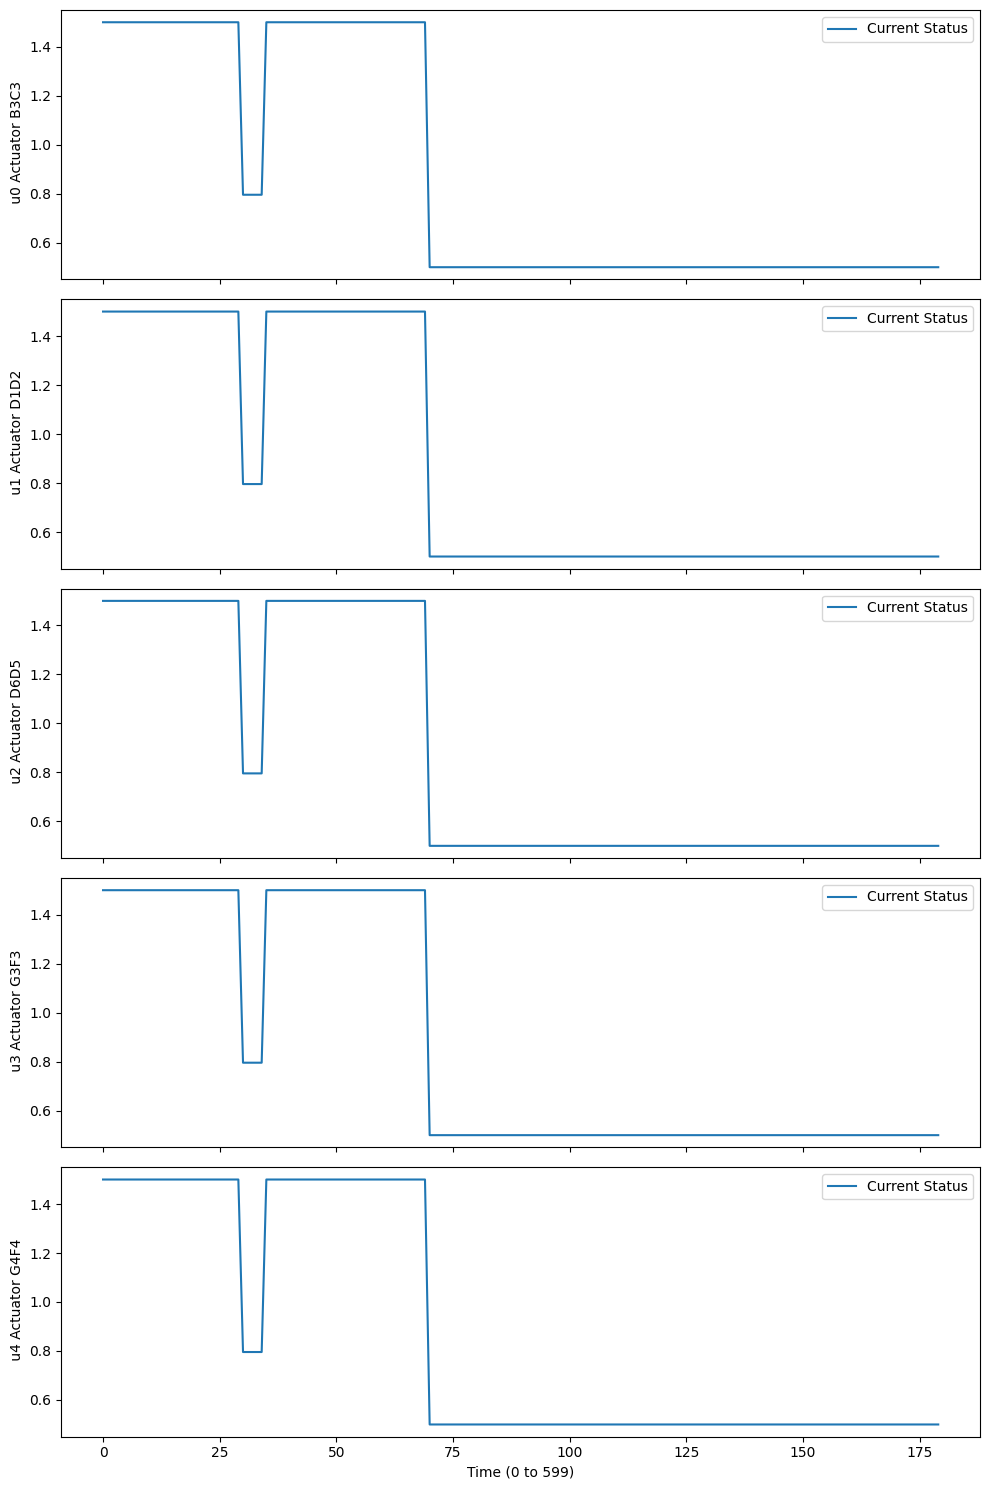

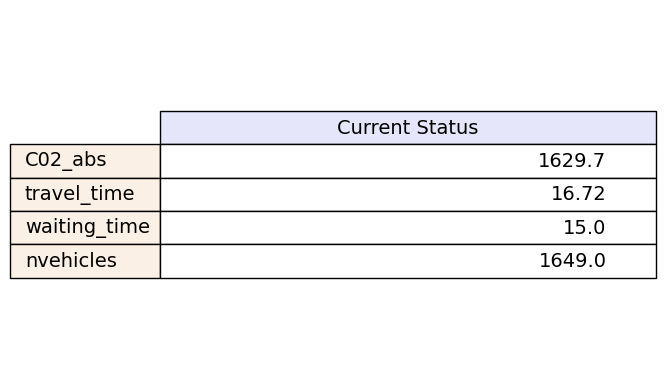

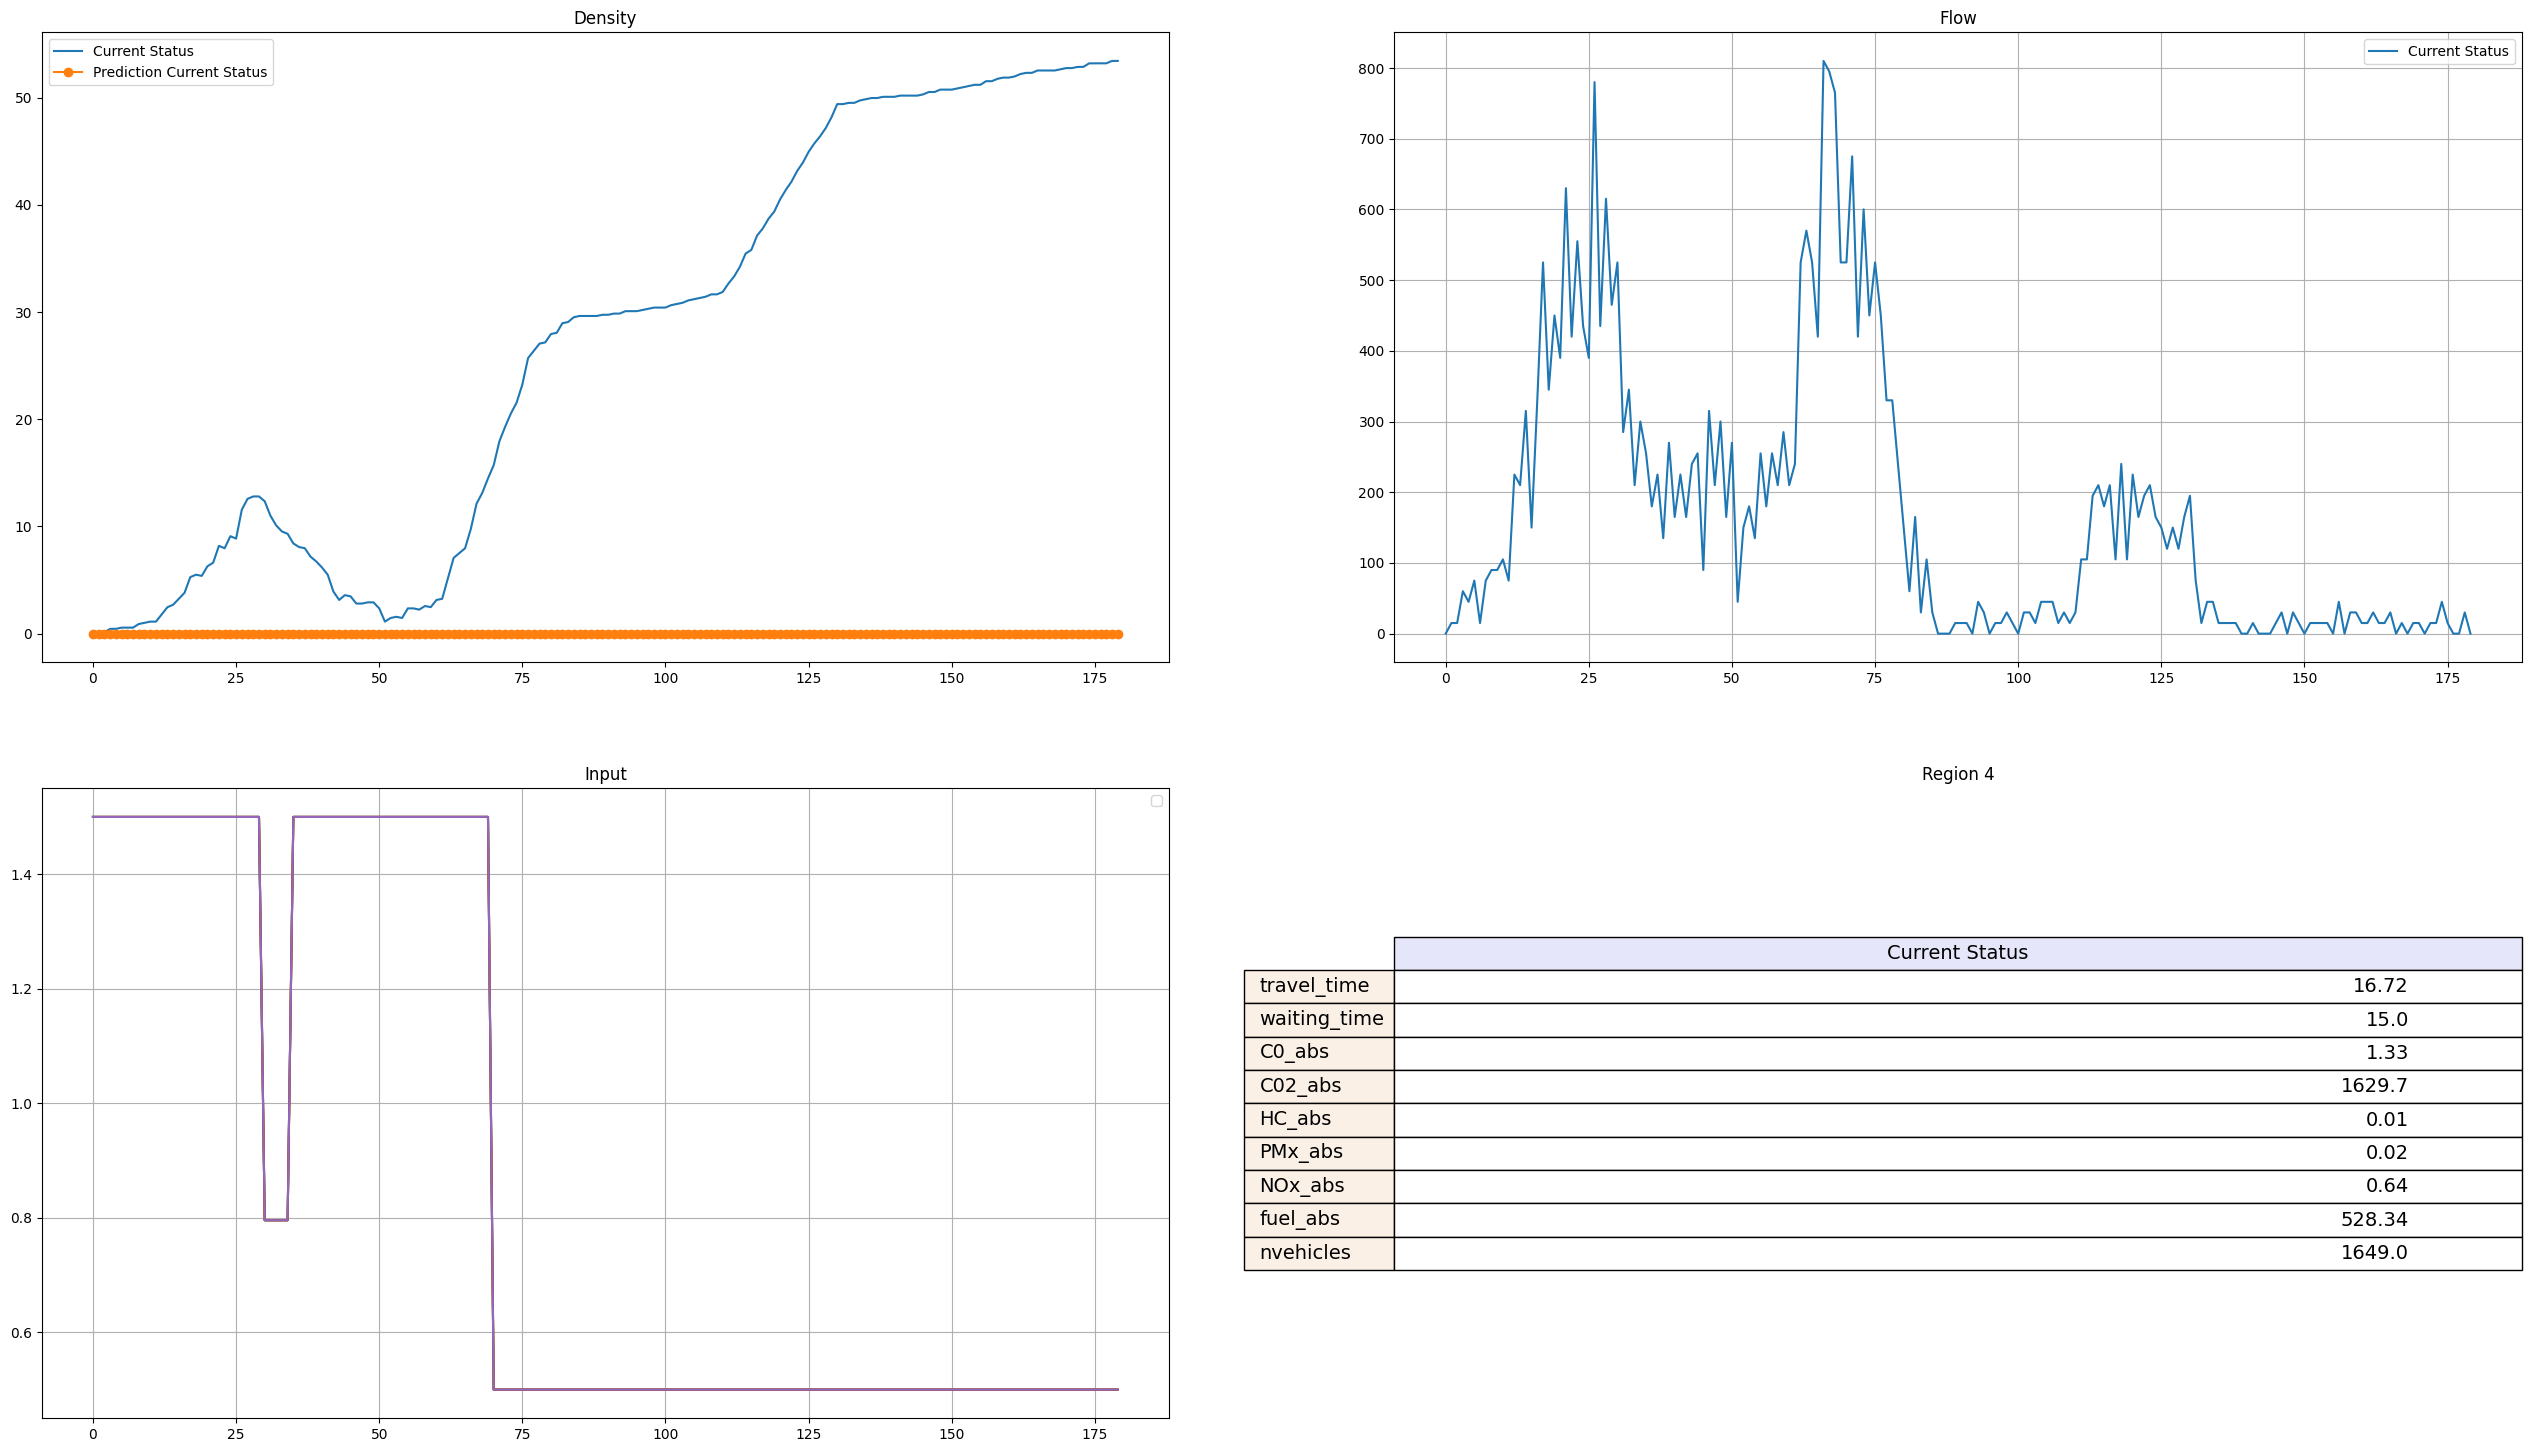

In [13]:
# First, the P controller and the ControlSim is built

class pController(Controller):  
    def __init__(self,actuators,params={}) -> None:
        '''Initialize the controller'''
        super().__init__(actuators,params)
        self.name='P'
        self.n_regions = params['n_regions']
    
        self.ul = self.safety[0] # lower bound on the input = 0.5
        self.uu = self.safety[1] # upper bound on the input = 1.5
    
        self.Kp = params['Kp']
    
    def get_next_input(self, n, target_region, r):
        '''Derive and check the inputs from the optimization
        Args:
            n: Current densities
            T: Current time
        Returns:
            Next inputs 
        '''
        self.r = r.copy()
        target_region_index = target_region - 1
        n = n.copy()[target_region_index]
        r = self.r.copy()[target_region_index]
    
        error = r - n
        u = 1 + self.Kp * error
    
        u = np.clip(u, self.ul, self.uu)
        
        return np.tile(u, 5)


class pControl_ControlSim(ControlSim):
    def __init__(self,network,taskparams,actuators,controlparams = {}):
        super().__init__(network=network,taskparams=taskparams,actuators=actuators,controlparams=controlparams)

    def compute_input(self, k, forecast, controller, controller_name, uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix, m, p, r, u_min, u_max):
        freq = 5
        if k % freq == 0:
            n = yMeasuredMatrix[:,k]
            target_region = 5
            u = controller.get_next_input(n, target_region, r)
            y = np.zeros(5) # No prediction, just assume it's flat
            return u, y
        else:
            return uAppliedMatrix[k-1,:], ySingleStepPredMatrix[k-1,:]




# Second, the Kp parameter is set and the P controller is simulated on the evaluation sim
if run_p_controller:
    pControl_control_params = {'Kp': 0.5} 
    
    dsl_task = DSL(taskparams, pControl_ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class
    controller_class = pController
    controller_json = pControl_control_params
    p_experiment = dsl_task.runtask(init_from_notebook=True, controller_class=controller_class, controller_json=controller_json)
    # runtask starts SUMO (the traffic sim)
    # "experiment" is the saved output of the simulation
    
    
    
    # Third, the relevant metrics and timeseries are plotted
    
    region = 'Region 4'
    com = Comparison([p_experiment], ['Current Status'], region=region)
    
    com.plot_density()
    com.plot_flow()
    com.plot_input()
    com.plot_metrics()
    com.plot()

As you can see in the performance metrics and density and flow timeseries above, the P controller performs better than no control but does not avoid gridlock at the end of the simulation.

In [14]:
if run_p_controller and generate_gif:
    # GIF Generation
    # [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
    %matplotlib agg 
    
    # This takes around 2 minutes (can be commented out)
    # (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
    output_dir = p_experiment.info['output_path'] # This is where the output of the experiment was saved.
    output_gif_path = "figs/p_controller_heatmap.gif"   # Specify where to save the density git file, can change to your own path
    cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 
    
    # Display saved GIF
    # [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
    %matplotlib inline
    display(Image(url=output_gif_path))
    plot_color_legend(cmap, norm)

# Your task

You are hired by COCO City to improve on the existing traffic control performance. 

To facilitate this, COCO City has provided you with the training data above, intended to be used with a data-driven controller, and the linearization parameters $A$, $B$, $C$, and $d$ above, intended to be used with a Model Predictive Controller.

COCO City does not know which controller will perform best, and are reliant upon you to provide a controller that improves performance and (hopefully) avoids gridlock in their downtown area.

To solve the optimization problem, we advise you to use the MOSEK solver (`problem.solve(solver=cp.MOSEK`), though you are welcome to use other solvers.
Implement your code below.



MPC Controller

Running Simulation...
 Retrying in 1 seconds
Step: 0
Step: 10
Step: 20
Step: 30
Step: 40


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step #3580.00 (0ms ?*RT. ?UPS, TraCI: 95ms, vehicles TOT 1703 ACT 85 BUF 0)               
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


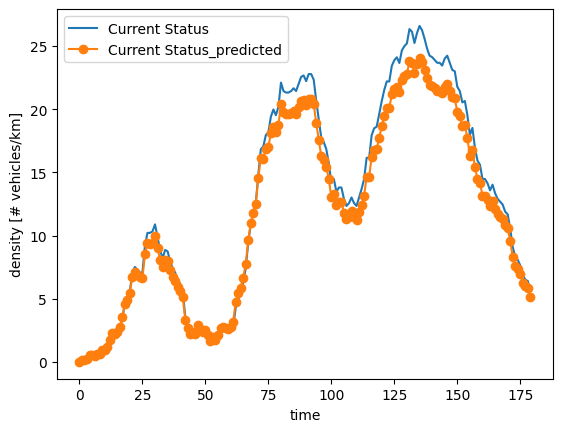

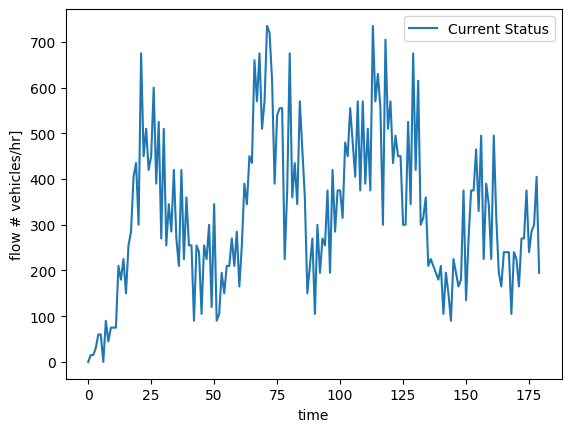

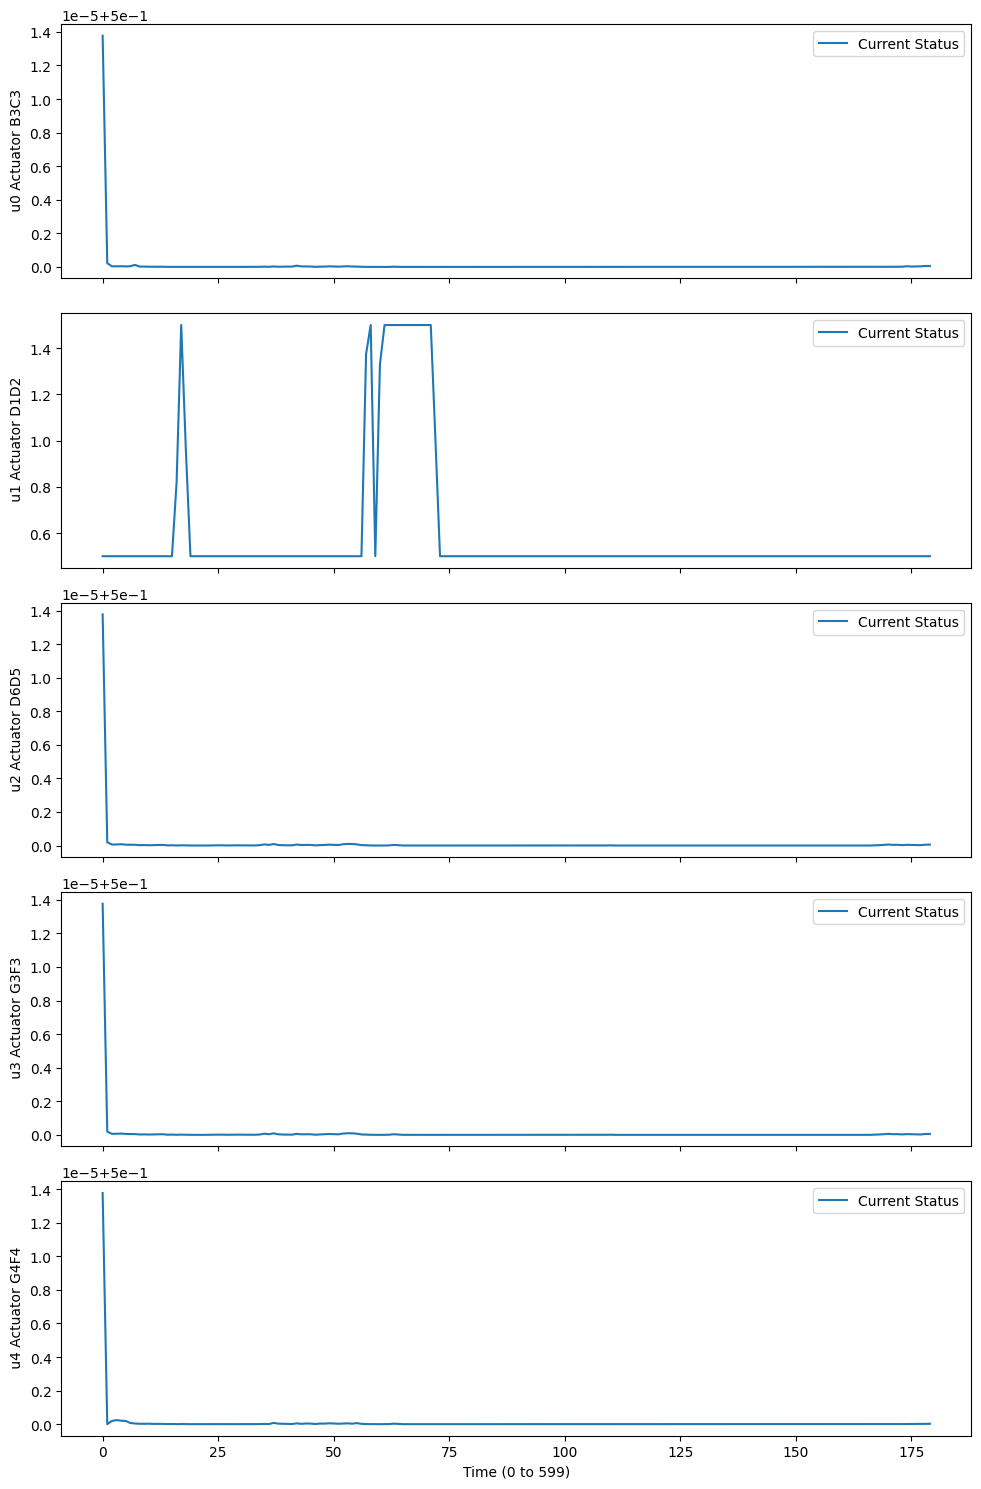

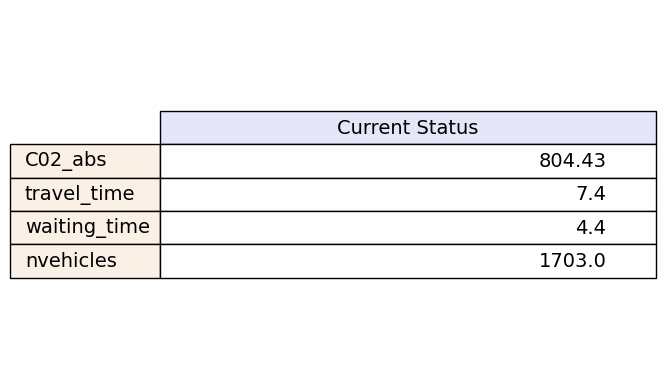

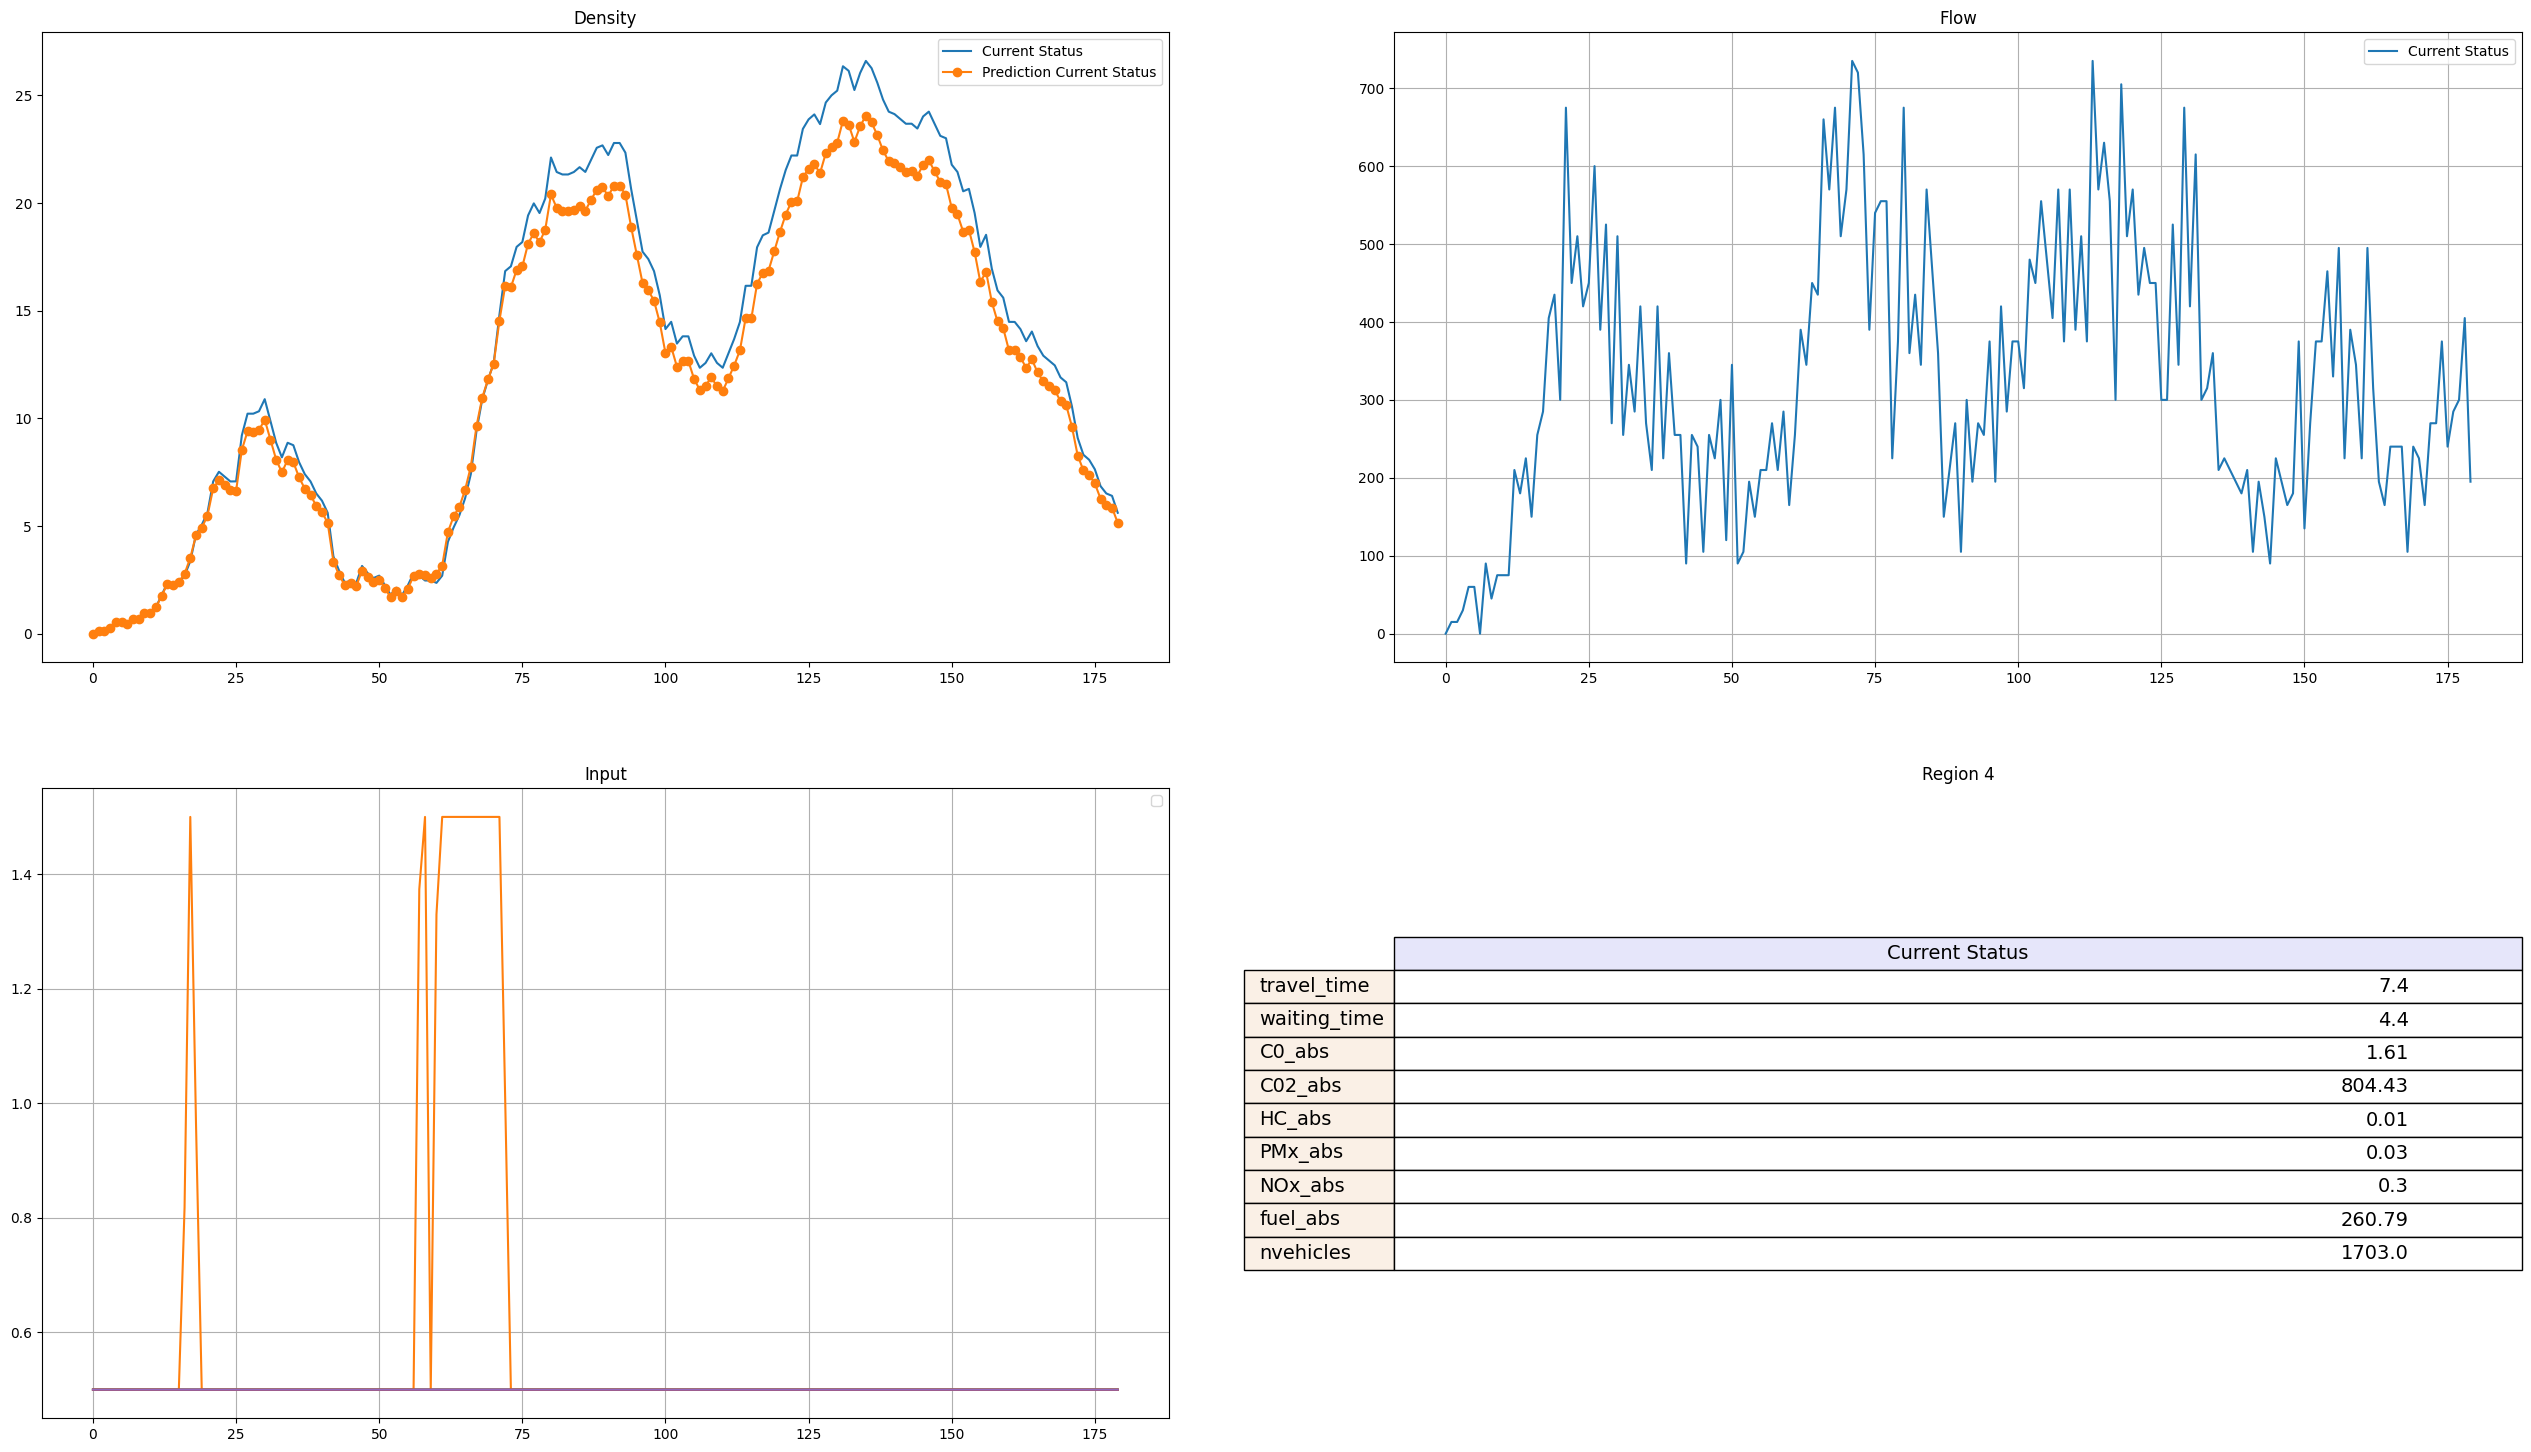

In [15]:
class mpcController(Controller):  
    def __init__(self, actuators, params={}):
        super().__init__(actuators, params)
        self.name = 'MPC'
        self.n_regions = params['n_regions']

        # MPC hyperparameters
        self.N = params['N']                          # Prediction horizon
        self.Q_weight = params['Q_weight']            # State tracking cost weight
        self.R_weight = params['R_weight']            # Control effort cost weight
        self.slack_weight = params['slack_penalty_weight']    # Slack penalty weight for soft constraints

        self.r_full_factor = params['r_full_factor']
        self.q_diag_factor = params['q_diag_factor']
        self.max_density_factor = params['max_density_factor']

        # Input bounds (safety limits)
        self.ul = self.safety[0]
        self.uu = self.safety[1]

        # Linearized model setup
        self.model = params['model']  # Model object from simulation (e.g. dsl_task.simulation.get_model())
        self.sim_period = params.get('sim_period', 20) 
        self.v_target = np.ones(self.n_regions)         # Nominal input used for linearization

    def compute_prediction_matrices(self, A, B, N):
        """
        Constructs the A_bar and B_bar matrices used for predicting system states over the horizon.
        These matrices express the relationship between future states and current state + future inputs.
        """
        nx, nu = B.shape
        A_bar = np.zeros((N * nx, nx))
        B_bar = np.zeros((N * nx, N * nu))
        for i in range(N):
            A_bar[i*nx:(i+1)*nx, :] = np.linalg.matrix_power(A, i+1)
            for j in range(i+1):
                B_bar[i*nx:(i+1)*nx, j*nu:(j+1)*nu] = np.linalg.matrix_power(A, i-j) @ B
        return A_bar, B_bar

    def get_next_input(self, rho_k, forecast, rho_ref):
        """
        Solves the MPC optimization problem for the next control input.
        Inputs:
            - rho_k: current densities (state) ∈ ℝ⁵
            - forecast: future demand/spawn vector q(k) ∈ ℝ⁵ˣᴺ
            - rho_ref: desired target density ∈ ℝ⁵
        Output:
            - u_opt: optimal control input ∈ ℝ⁵
            - y_pred: predicted next state
        """

        # Proactively reduce the desired density in the central region 
        # to anticipate future congestion and encourage earlier traffic evacuation
        target_region = 5
        r_full = rho_ref.copy()
        r_full[target_region - 1] *= self.r_full_factor

        # Linearize model at current state
        A, B, C, d = self.model.linearize(self.sim_period, rho_k, self.v_target)

        # Construct reference trajectory for the entire horizon
        ref = np.tile(r_full.reshape(-1, 1), (self.N, 1))

        # Adaptive state penalty matrix Q based on current deviation from reference
        Q_diag = 1.0 + self.q_diag_factor * np.maximum(0, (rho_k - r_full) / r_full)
        Q_adaptive = np.diag(Q_diag) * self.Q_weight

        # Build lifted prediction matrices
        nx, nu = B.shape
        A_bar, B_bar = self.compute_prediction_matrices(A, B, self.N)
        C_bar = np.kron(np.eye(self.N), C)  # Block-diagonal form
        d_bar = np.tile(d.reshape(-1, 1), (self.N, 1))  # Offset over horizon

        # Optimization variables
        x = cp.Variable((self.N * nx, 1))        # Predicted state trajectory
        u = cp.Variable((self.N * nu, 1))        # Control inputs
        slack = cp.Variable((self.N * nx, 1))    # Slack for soft constraints

        # Process and reshape forecast demand
        q_bar = forecast[:, :self.N]
        if q_bar.shape[1] < self.N:
            pad = np.zeros((5, self.N - q_bar.shape[1]))
            q_bar = np.hstack([q_bar, pad])
        q_bar = q_bar.reshape(-1, 1, order='F')

        # Define the cost function
        Q_block = np.kron(np.eye(self.N), Q_adaptive)
        R_block = np.eye(self.N * nu) * self.R_weight
        cost = (
            cp.quad_form(x - ref, Q_block) +      # Penalize deviation from reference
            cp.quad_form(u, R_block) +            # Penalize control effort
            cp.sum_squares(slack) * self.slack_weight  # Penalize constraint violation
        )

        # Define soft upper bounds on traffic density: we allow the predicted densities
        # to slightly exceed the reference (rho_ref) by a factor specified via max_density_factor.
        # This provides a margin for safety while allowing the optimizer some flexibility,
        # helping to avoid infeasibility when congestion builds up.
        max_density = r_full.reshape(-1, 1) * self.max_density_factor
        x_max = np.tile(max_density, (self.N, 1))

        constraints = [
            x == A_bar @ rho_k.reshape(-1, 1) + B_bar @ u + C_bar @ q_bar + d_bar,  # Dynamics
            u >= self.ul,
            u <= self.uu,
            x >= 0,
            x <= x_max + slack,
            slack >= 0
        ]

        # Solve the optimization problem
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.MOSEK)

        if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            print(f"[MPC] Solver failed: {prob.status}")
            return np.ones(nu), rho_k  # Fallback: return default input

        u_opt = np.clip(u.value[:nu].flatten(), self.ul, self.uu)  # Apply input limits again
        y_pred = A @ rho_k + B @ u_opt + C @ forecast[:, 0] + d    # Predict next state

        return u_opt, y_pred


class mpcControl_ControlSim(ControlSim):
    def compute_input(self, k, forecast, controller, controller_name,
                      uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix,
                      m, p, r, u_min, u_max):
        """
        Called at each timestep to compute the input using the MPC controller.
        """
        freq = 1
        if k % freq == 0:
            if k % 10 == 0:
                print("Step:", k)

            rho_k = yMeasuredMatrix[:, k]
            forecast_q = forecast.T  # shape: (5, T)

            forecast_horizon = forecast_q[:, k:k+controller.N]
            if forecast_horizon.shape[1] < controller.N:
                pad = np.zeros((5, controller.N - forecast_horizon.shape[1]))
                forecast_horizon = np.hstack([forecast_horizon, pad])

            u, y = controller.get_next_input(rho_k, forecast_horizon, r)
            return u, y

        else:
            return uAppliedMatrix[k-1, :], ySingleStepPredMatrix[k-1, :]


# Controller parameters
mpc_control_params = {
    'N': 10,
    'Q_weight': 1.0,
    'R_weight': 0.01,
    'slack_penalty_weight': 1200.0,
    'r_full_factor': 0.8,
    'q_diag_factor': 50.0,
    'max_density_factor': 1.2,
    'n_regions': 5,
    'model': dsl_task.simulation.get_model()
}

if run_mpc_controller:
# Create and run task
    dsl_task = DSL(taskparams, mpcControl_ControlSim)
    mpc_experiment = dsl_task.runtask(init_from_notebook=True, controller_class=mpcController, controller_json=mpc_control_params)
    
    # Plot results
    region = 'Region 4'
    com = Comparison([mpc_experiment], ['Current Status'], region=region)
    com.plot_density()
    com.plot_flow()
    com.plot_input()
    com.plot_metrics()
    com.plot()


In [16]:
if run_mpc_controller and generate_gif:
    # GIF Generation
    # [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
    %matplotlib agg 
    
    # This takes around 2 minutes (can be commented out)
    # (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
    output_dir = mpc_experiment.info['output_path'] # This is where the output of the experiment was saved.
    output_gif_path = "figs/mpc_controller_heatmap.gif"   # Specify where to save the density git file, can change to your own path
    cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 
    
    # Display saved GIF
    # [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
    %matplotlib inline
    display(Image(url=output_gif_path))
    plot_color_legend(cmap, norm)

Data Driven

Running Simulation...
 Retrying in 1 seconds
Step: 10
Step: 20
Step: 30
Step: 40


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step: 50
Step: 60
Step: 70
Step: 80
Step: 90
Step: 100
Step: 110
Step: 120
Step: 130
Step: 140
Step: 150
Step: 160
Step: 170
Step #3580.00 (0ms ?*RT. ?UPS, TraCI: 222ms, vehicles TOT 1703 ACT 42 BUF 0)              
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


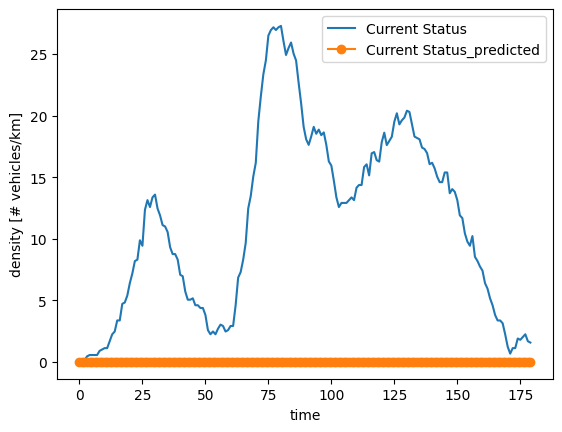

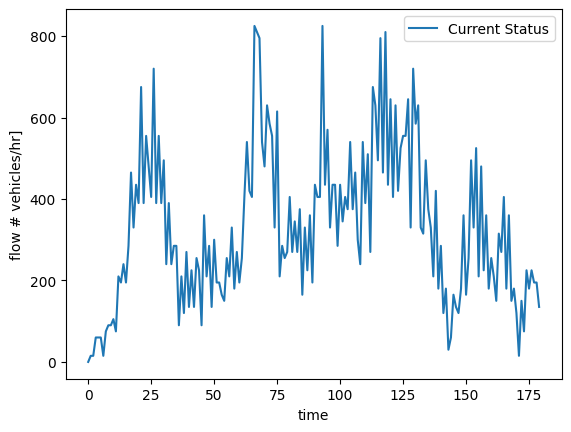

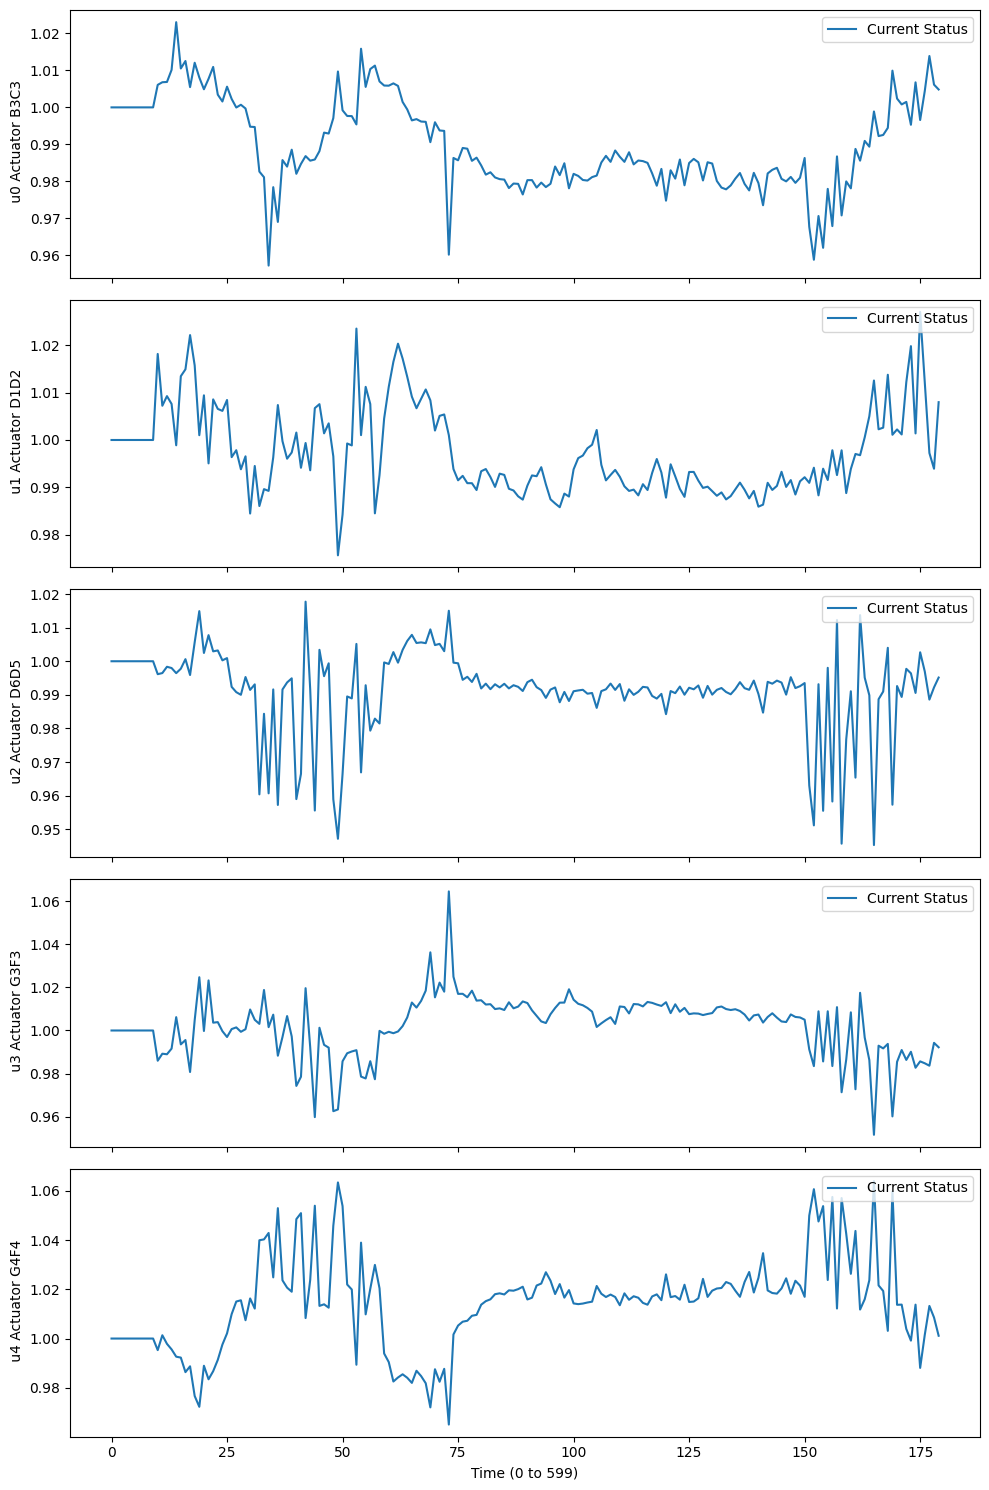

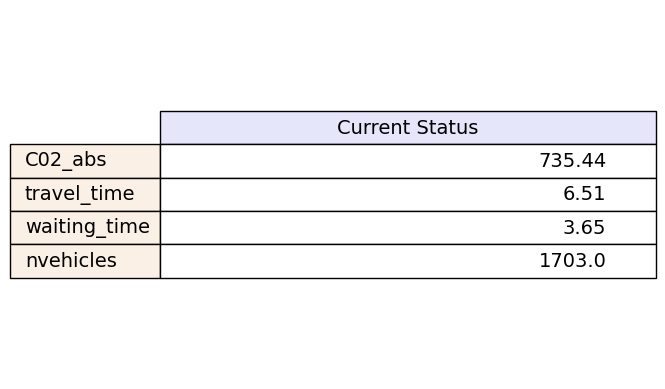

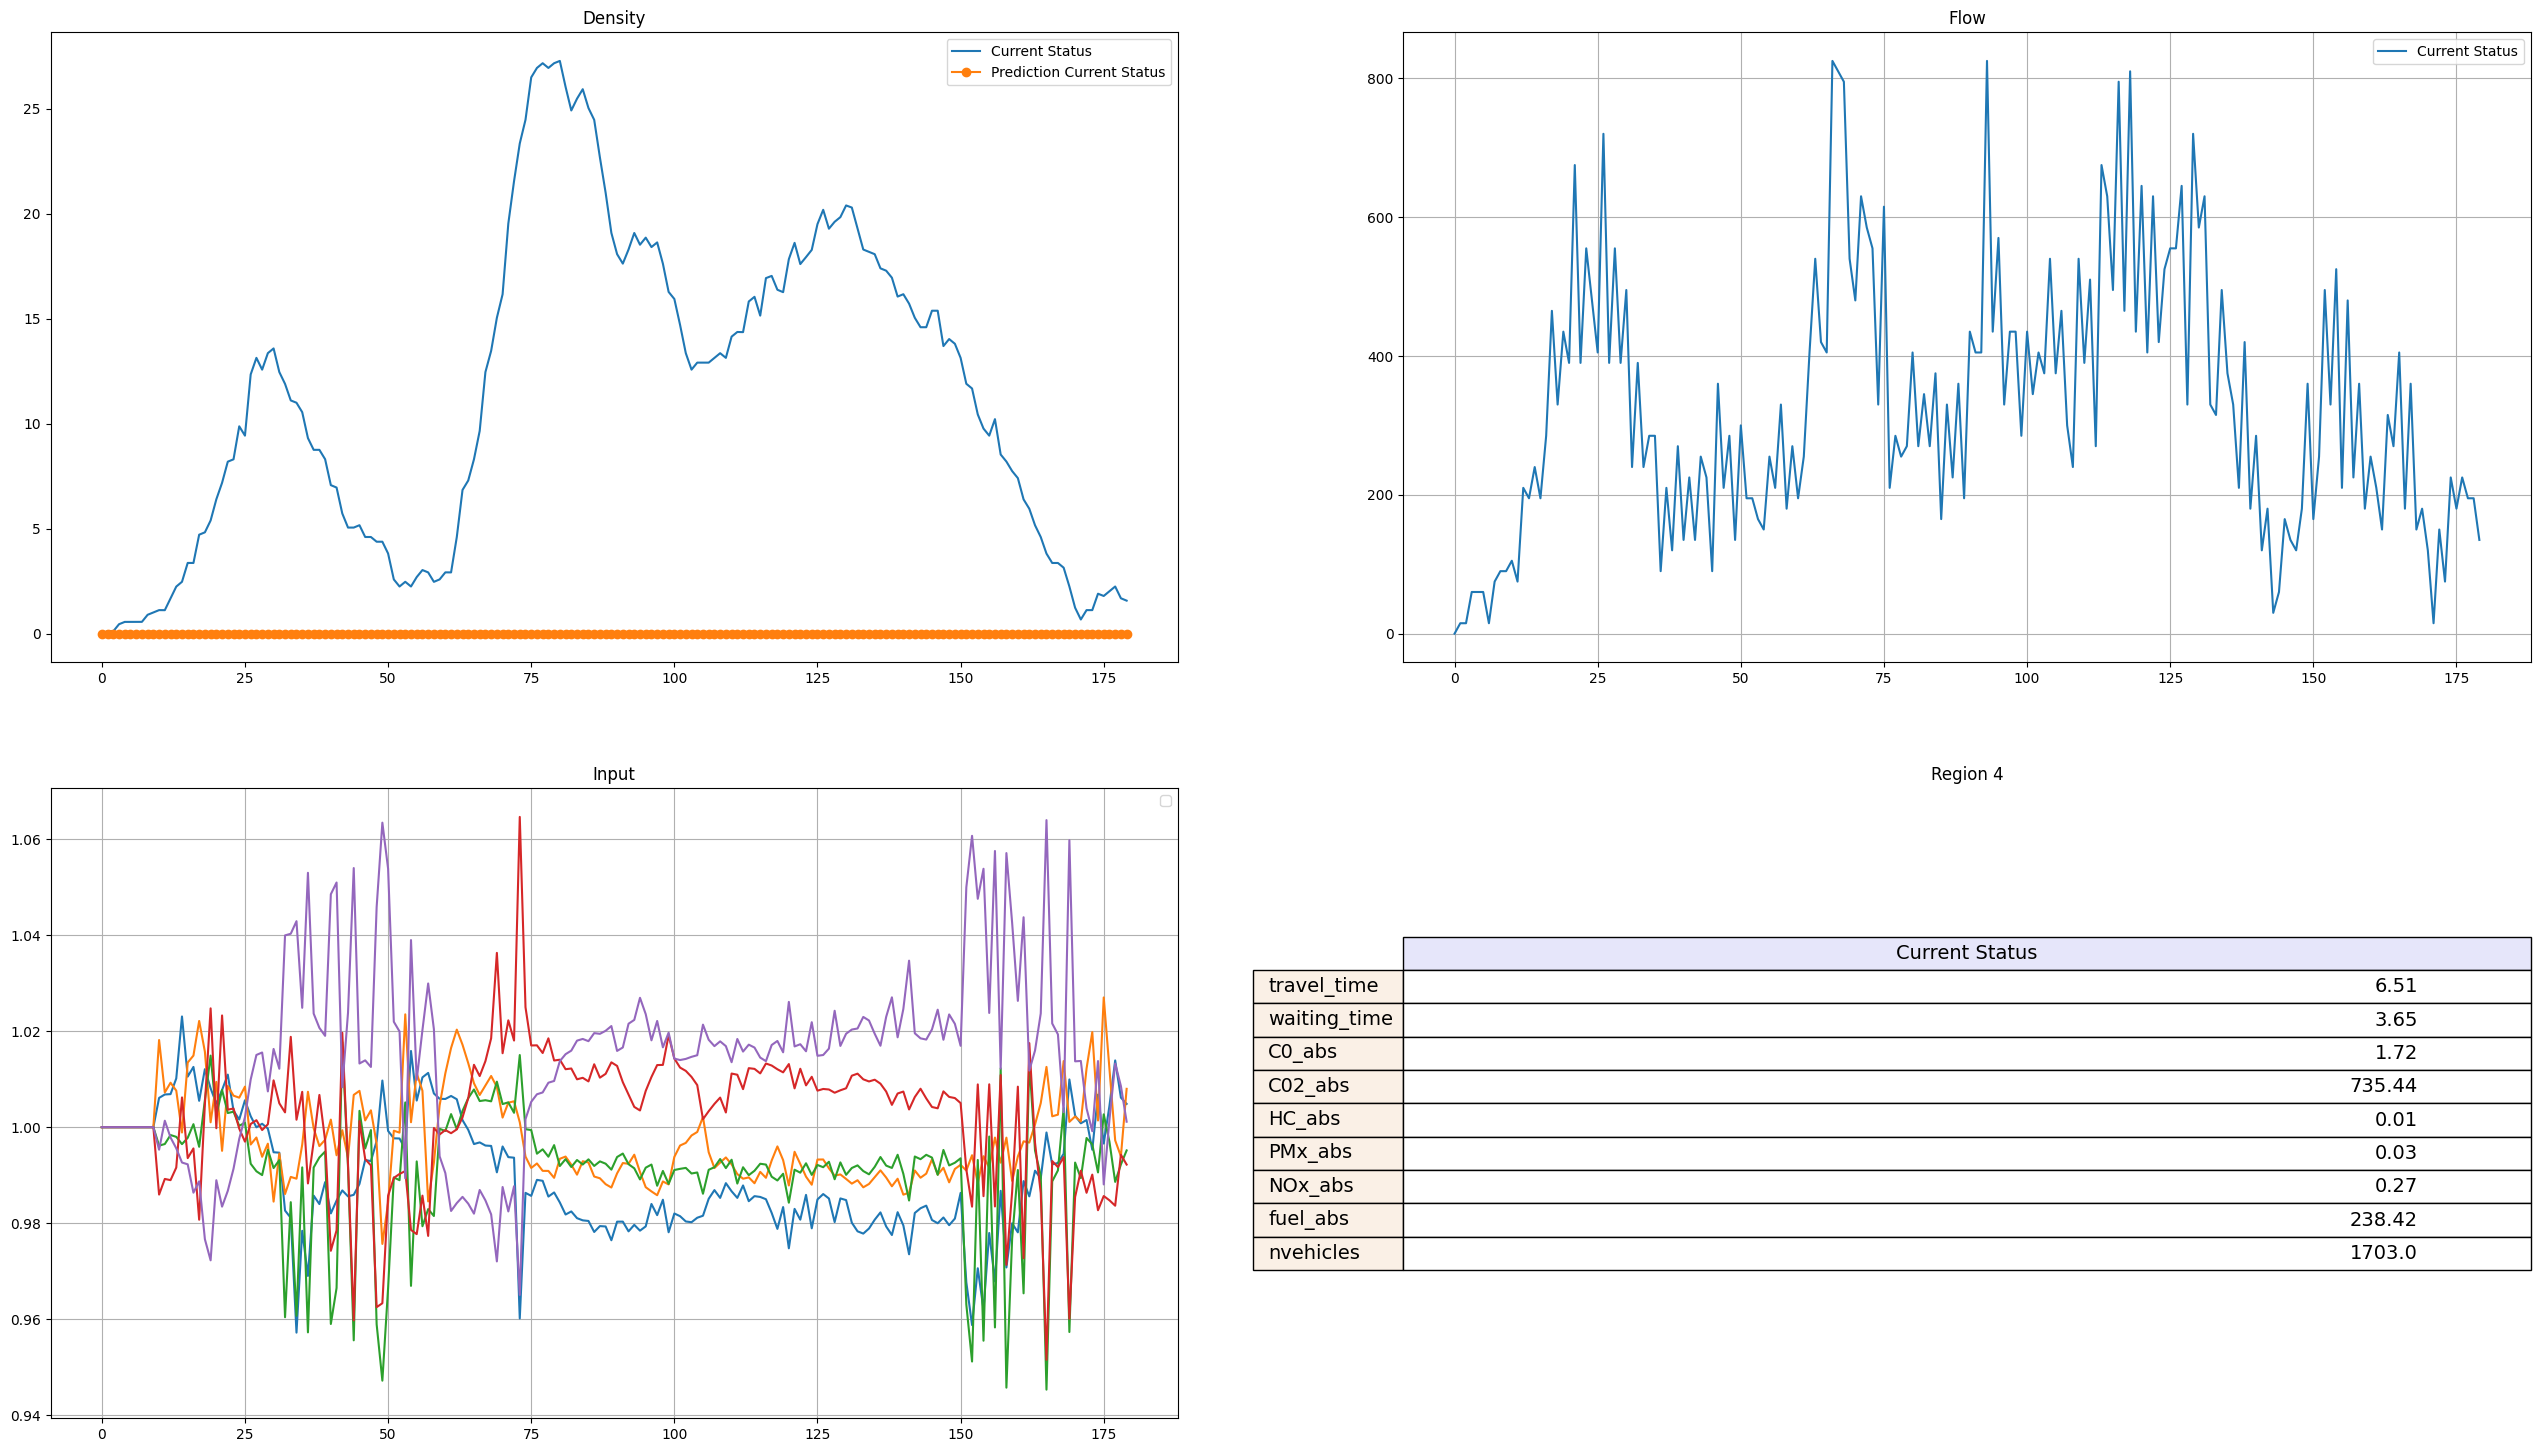

In [17]:
class dataDrivenController(Controller):
    def __init__(self, actuators, params={}):
        """
        Data-Driven Controller (DeePC-based) using past input-output trajectories.

        Parameters:
        - n_regions: number of regions in the traffic network
        - rho: number of past time steps (past horizon)
        - K: prediction horizon
        - Q_weight: weight on tracking error
        - R_weight: weight on control effort
        - csv_path: path to the CSV file with past I/O data
        """
        super().__init__(actuators, params)
        self.name = 'DataDriven'
        
        self.n_regions = params['n_regions']  # Number of traffic regions

        self.ul = self.safety[0]              # Min input (e.g. speed factor lower bound)
        self.uu = self.safety[1]              # Max input (e.g. speed factor upper bound)
        
        self.rho = params['rho']              # Past horizon length
        self.K = params['K']                  # Prediction horizon
        
        self.Q_weight = params['Q_weight']    # Weight on tracking error
        self.R_weight = params['R_weight']    # Weight on input effort
        
        self.congestion_penalty = params['congestion_penalty']        # Extra penalty for congestion
        self.max_density_factor = params['max_density_factor']        # Max density = ref * factor
        self.slack_penalty_weight = params['slack_penalty_weight']    # Penalty for constraint violation
        

        self.load_io_data(params.get('csv_path'))   # Load data from CSV
        self.build_hankel_matrices()                # Construct Hankel matrices from data

    def load_io_data(self, csv_path):
        """
        Load historical input-output data from CSV file and construct U and Y matrices.

        - U: shape (m, T) where m = number of inputs
        - Y: shape (p, T) where p = number of outputs (densities)
        """
        io_data = pd.read_csv(csv_path)
        self.U = io_data[[f'Speed limit factor for road {i}' for i in range(self.n_regions)]].values.T
        self.Y = io_data[[f'Density in Region {i}' for i in range(self.n_regions)]].values.T

    def build_hankel_matrices(self):
        """
        Constructs Hankel matrices using past data for use in DeePC optimization.
        These are block matrices representing all overlapping sequences of past data.
        """
        m, T = self.U.shape
        p = self.Y.shape[0]
        L = self.rho + self.K  # Total window length

        T_eff = T - L + 1      # Number of valid windows

        def hankel_matrix(data, block_rows, cols):
            return np.vstack([data[:, i:i+cols] for i in range(block_rows)])

        # Build extended Hankel matrices
        self.H_u = hankel_matrix(self.U, L, T_eff)
        self.H_y = hankel_matrix(self.Y, L, T_eff)

        # Split Hankel matrices into past and future blocks
        self.H_up = self.H_u[:self.rho*m, :]      # Past input block
        self.H_uf = self.H_u[self.rho*m:, :]      # Future input block
        self.H_yp = self.H_y[:self.rho*p, :]      # Past output block
        self.H_yf = self.H_y[self.rho*p:, :]      # Future output block

    def get_next_input(self, n, target_region, r, u_past, y_past):
        """
        Solves the DeePC optimization problem to predict the best control input.

        Inputs:
        - n: current measured state (densities) ∈ ℝ^p
        - target_region: region of interest (used for display)
        - r: reference densities ∈ ℝ^p
        - u_past: column vector of past inputs (rho * m, 1)
        - y_past: column vector of past outputs (rho * p, 1)

        Returns:
        - u: next input to apply (m,)
        - y_pred: predicted next state (p,)
        """
        m, p = self.n_regions, self.n_regions

        n0 = n.copy()
        r_full = r.copy()

        # Reference trajectory over the prediction horizon
        ref = np.tile(r_full.reshape(-1, 1), (self.K, 1))

        # Adaptive output penalty (Q) — prioritizes reducing excess density
        Q_diag = np.ones(p)
        for i in range(p):
            if n0[i] > r_full[i]:
                Q_diag[i] += self.congestion_penalty  # Apply heavier penalty if region is congested

        Q_block = np.kron(np.eye(self.K), np.diag(Q_diag)) * self.Q_weight
        R_block = np.eye(m * self.K) * self.R_weight

        # Optimization variables
        g = cp.Variable((self.H_up.shape[1], 1))      # Weights for Hankel combination
        u = self.H_uf @ g                             # Predicted future inputs
        y = self.H_yf @ g                             # Predicted future outputs
        slack_y = cp.Variable((p * self.K, 1))        # Slack variables for soft constraints

        # Maximum allowed density (soft upper bound)
        y_max = np.tile(r_full.reshape(-1, 1) * self.max_density_factor, (self.K, 1))

        # Constraints
        constraints = [
            self.H_up @ g == u_past,    # Match past input
            self.H_yp @ g == y_past,    # Match past output
            u >= self.ul,
            u <= self.uu,
            y <= y_max + slack_y,       # Soft constraint with slack
            slack_y >= 0
        ]

        # Cost: tracking error + input effort + soft constraint penalty
        slack_penalty = cp.sum_squares(slack_y) * self.slack_penalty_weight
        cost = cp.quad_form(y - ref, Q_block) + cp.quad_form(u, R_block) + slack_penalty

        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.MOSEK)

        return u.value[:m].flatten(), y.value[:p].flatten()


class dataDrivenControl_ControlSim(ControlSim):
    def compute_input(self, k, forecast, controller, controller_name,
                      uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix,
                      m, p, r, u_min, u_max):
        """
        Calls the data-driven controller at each time step after enough history is collected.

        k: current time step
        forecast: not used in DeePC (model-free)
        r: reference trajectory (optimal densities for each region)
        """
        freq = 1
        rho = controller.rho
        target_region = 5
        region_index = target_region - 1

        if k >= rho and k % freq == 0:
            # Extract past inputs and outputs
            u_past_matrix = uAppliedMatrix[k - rho:k, :].T
            y_past_matrix = yMeasuredMatrix[:, k - rho:k]

            # Flatten matrices column-wise to match Hankel constraints
            u_past = u_past_matrix.T.reshape(-1, 1, order='F')
            y_past = y_past_matrix.T.reshape(-1, 1, order='F')

            # Current measurement
            n = yMeasuredMatrix[:, k]

            # Get next input and prediction
            u, y_pred = controller.get_next_input(n, target_region, r, u_past, y_past)

            # Store single-step prediction for the region of interest
            ySingleStepPredMatrix[k, :] = 0
            ySingleStepPredMatrix[k, region_index] = y_pred[region_index]

            if k % 10 == 0:
                print(f"Step: {k}")
            y = np.zeros(p)
            return u, y
        else:
            # Warm-up period: apply neutral input
            u_fallback = np.full((m,), 1.0)
            y_fallback = np.zeros(p)
            ySingleStepPredMatrix[k, :] = 0
            ySingleStepPredMatrix[k, region_index] = y_fallback[region_index]

            return u_fallback, y_fallback



data_driven_control_params = {
    'rho': 10,
    'K': 10,
    'Q_weight': 1.0,
    'R_weight': 0.0,
    'n_regions': 5,
    'csv_path': './dep/sumo_files/cocoCity/control/edge/io_data.csv',
    'congestion_penalty': 200.0,
    'max_density_factor': 1.4,
    'slack_penalty_weight': 1000.0
}

if run_data_driven_controller:
    dsl_task = DSL(taskparams, dataDrivenControl_ControlSim)
    data_driven_experiment = dsl_task.runtask(init_from_notebook=True, controller_class=dataDrivenController, controller_json=data_driven_control_params)
    
    
    
    # Third, the relevant metrics and timeseries are plotted
    
    region = 'Region 4'
    com = Comparison([data_driven_experiment], ['Current Status'], region=region)
    
    com.plot_density()
    com.plot_flow()
    com.plot_input()
    com.plot_metrics()
    com.plot()



In [18]:
if run_data_driven_controller and generate_gif:
    # GIF Generation
    # [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
    %matplotlib agg 
    
    # This takes around 2 minutes (can be commented out)
    # (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
    output_dir = data_driven_experiment.info['output_path'] # This is where the output of the experiment was saved.
    output_gif_path = "figs/data_driven_controller_heatmap.gif"   # Specify where to save the density git file, can change to your own path
    cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 
    
    # Display saved GIF
    # [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
    %matplotlib inline
    display(Image(url=output_gif_path))
    plot_color_legend(cmap, norm)

BONUS

Running Simulation...
 Retrying in 1 seconds
Step 0
Step 10
Step 20
Step 30
Step 40


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step 50
Step 60
Step 70
Step 80
Step 90
Step 100
Step 110
Step 120
Step 130
Step 140
Step 150
Step 160
Step 170
Step #3580.00 (0ms ?*RT. ?UPS, TraCI: 126ms, vehicles TOT 1703 ACT 118 BUF 0)             
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


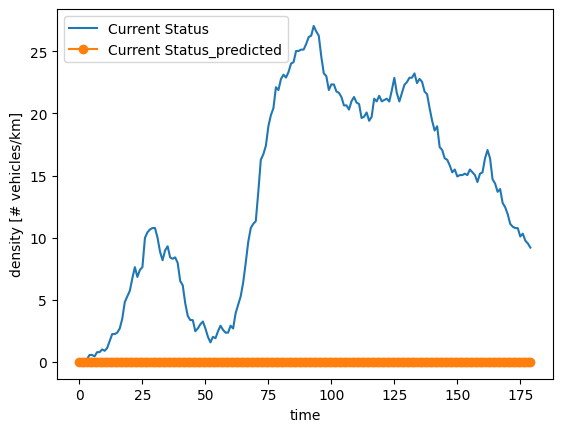

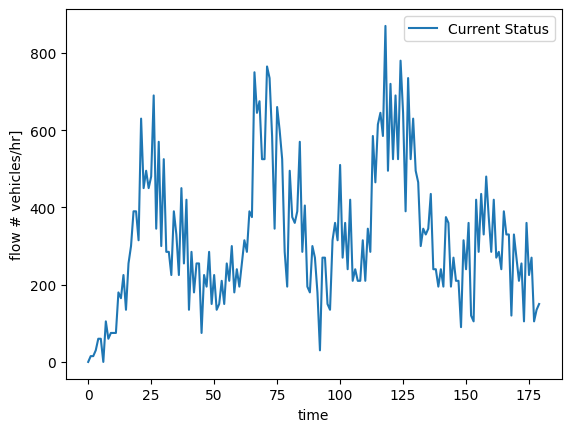

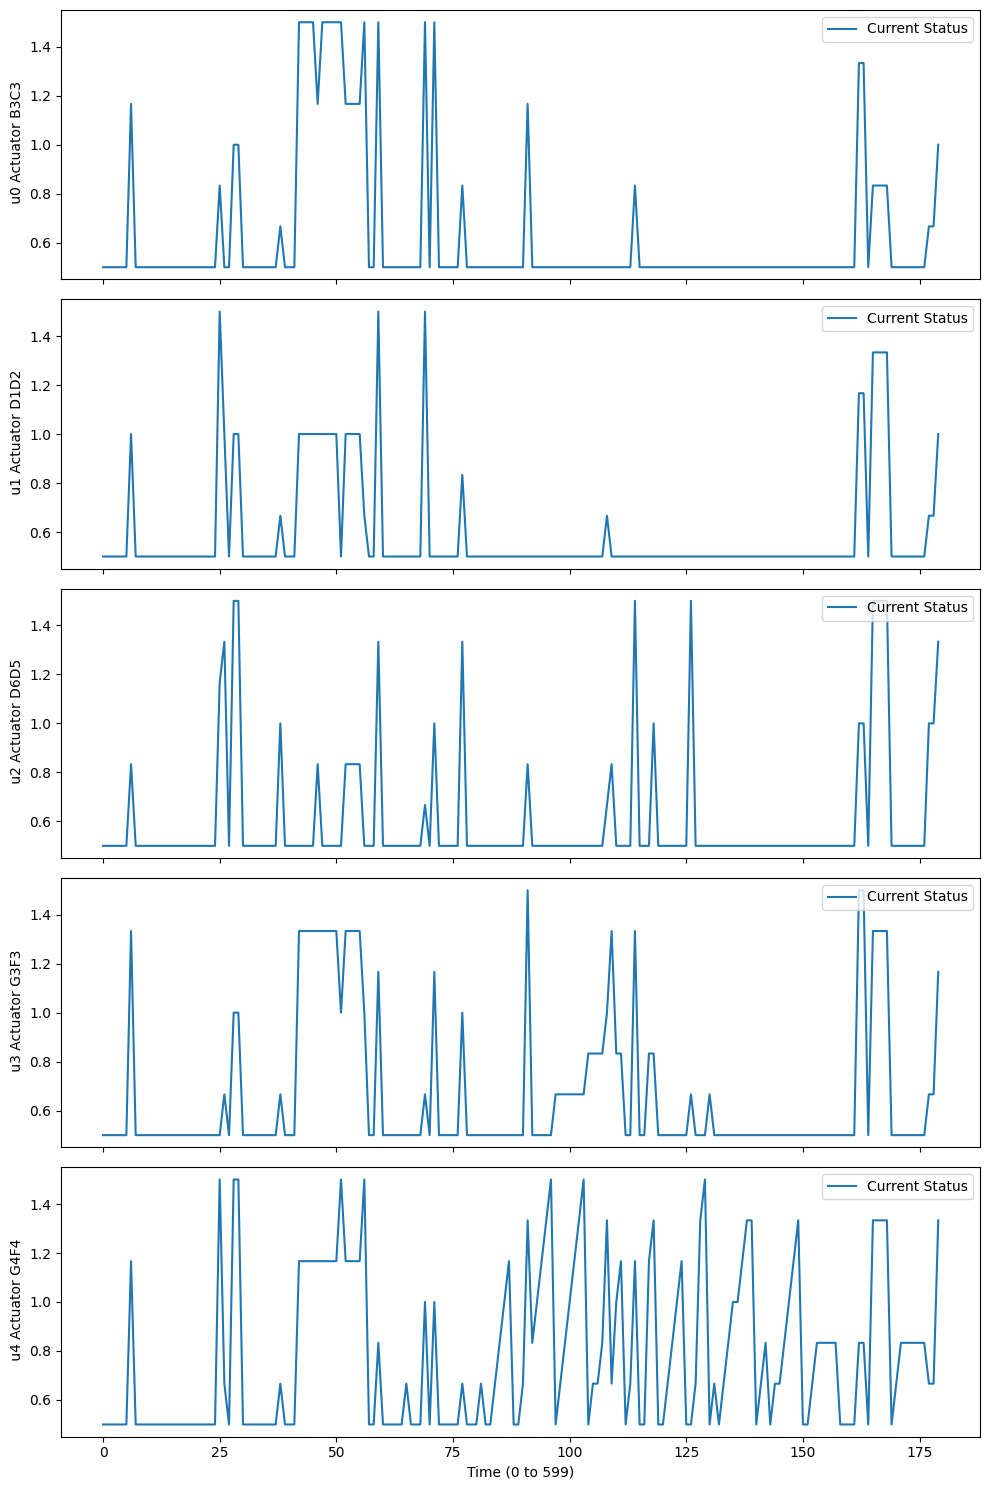

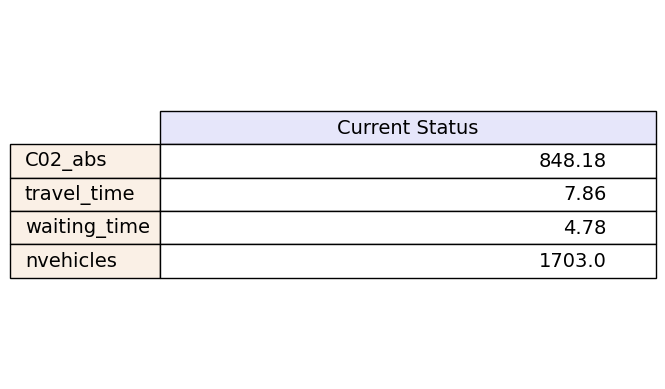

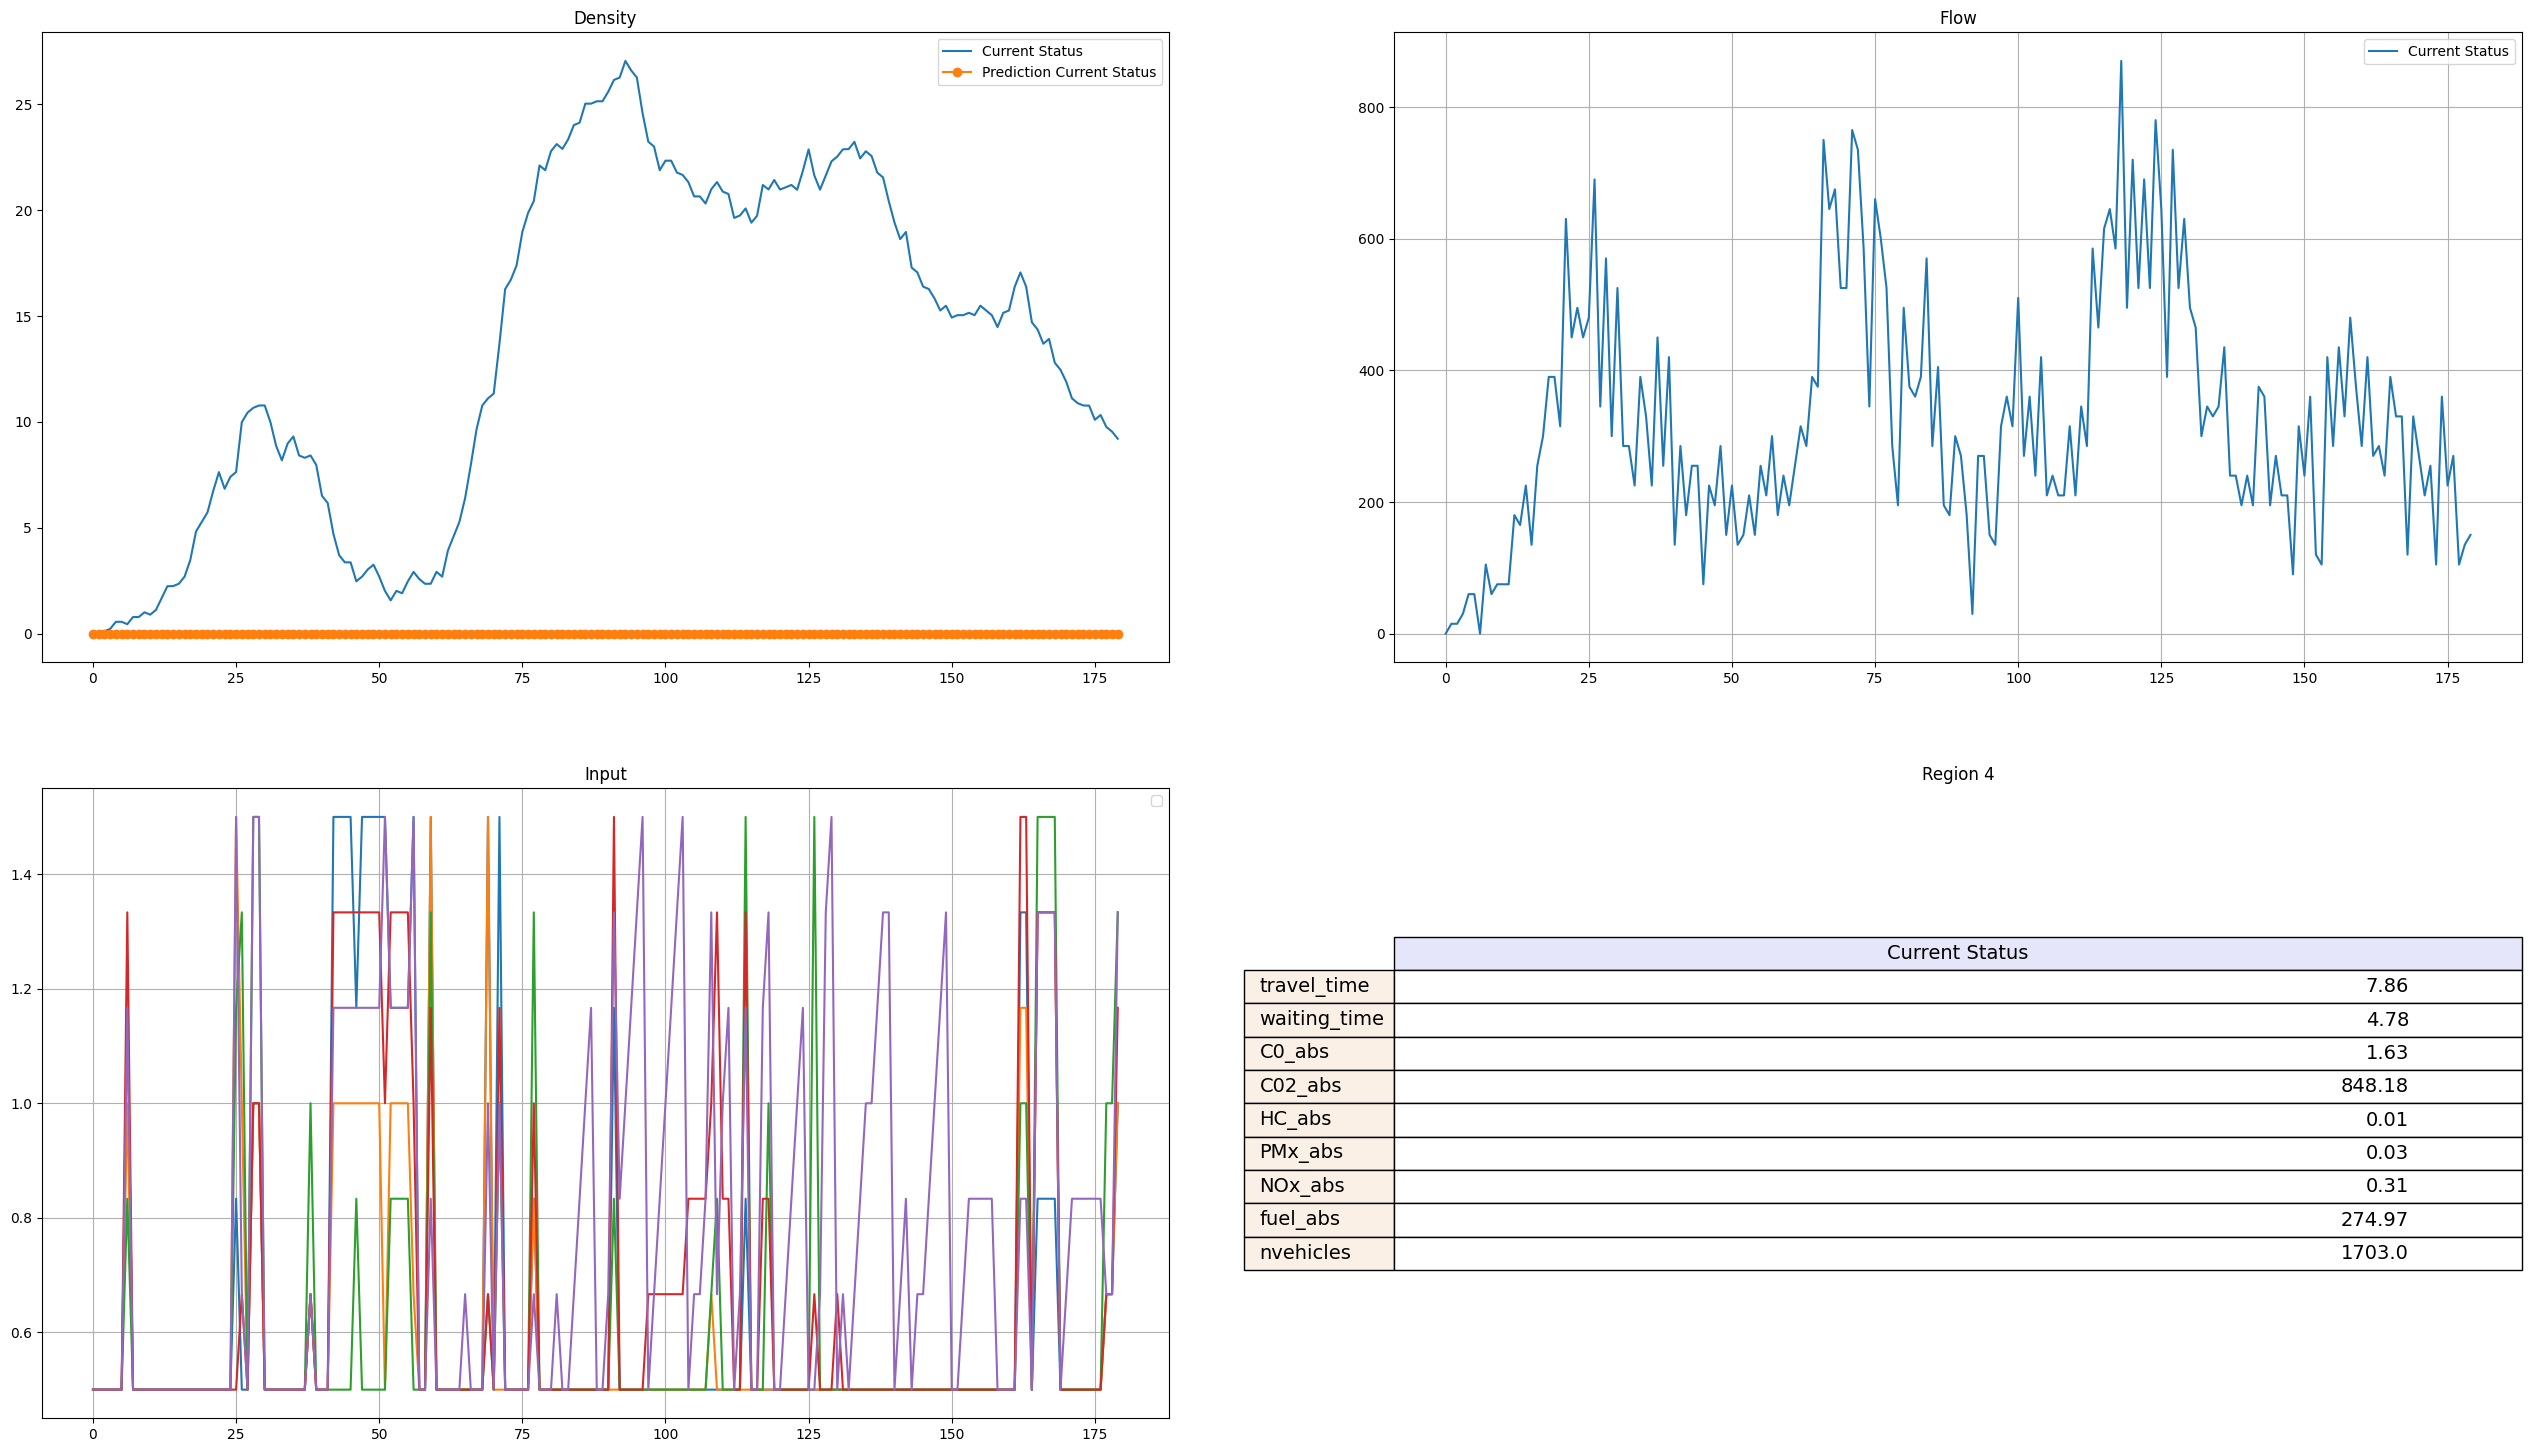

In [19]:
import random

class qLearningController(Controller):
    def __init__(self, actuators, params={}):
        """
        Tabular Q-learning controller for traffic management.
        Learns optimal control actions based on discrete traffic states.
        """
        super().__init__(actuators, params)
        self.name = 'Q-Learning'
        self.n_regions = params['n_regions']
        self.ul = self.safety[0]  # Lower bound on control input (e.g., 0.5)
        self.uu = self.safety[1]  # Upper bound on control input (e.g., 1.5)

        # Q-learning hyperparameters
        self.alpha = params['alpha']                # Learning rate
        self.gamma = params['gamma']                # Discount factor for future rewards
        self.epsilon = params['epsilon']            # Exploration rate
        self.n_bins = params['n_bins']              # Number of bins to discretize densities
        self.action_set = np.linspace(self.ul, self.uu, params['n_actions'])      # Discrete set of possible actions
                                    

        # Reward tuning parameters 
        self.central_threshold = params.get('central_threshold', 20.0)         # Congestion threshold for region 5
        self.reward_density_weight = params.get('reward_density_weight', 8.5)  # Bonus multiplier for reducing density
        self.input_bonus_horizon = params.get('input_bonus_horizon', 70)       # Apply bonus in early steps for higher inp
        self.input_bonus_weight = params.get('input_bonus_weight', 100.0)      # Input bonus scaling factor

        # Random seed for reproducibility 
        seed = params.get('seed', 42)
        np.random.seed(seed)
        random.seed(seed)

        # Initialize Q-table and history tracking
        self.q_table = {}           # Maps (discretized state) → Q-values per action
        self.prev_state = None      # Last observed state
        self.prev_action = None     # Last action taken

        # Discretize densities over fixed range [0, 20] 
        self.bin_edges = np.linspace(0, 20, self.n_bins + 1)

    def discretize_state(self, density):
        """Convert continuous densities to a tuple of discrete bin indices."""
        return tuple(np.digitize(density, self.bin_edges) - 1)

    def discretize_action(self, action):
        """Find closest discrete action index for each control value."""
        return tuple(np.abs(self.action_set[:, None] - action).argmin(axis=0))

    def select_action(self, state):
        """Select action via epsilon-greedy policy."""
        if state not in self.q_table:
            # Initialize Q-values for unseen state
            self.q_table[state] = np.zeros([len(self.action_set)] * self.n_regions)

        if np.random.rand() < self.epsilon:
            # With epsilon probability: explore
            action_indices = tuple(np.random.randint(len(self.action_set)) for _ in range(self.n_regions))
        else:
            # Otherwise: exploit best known action
            action_indices = np.unravel_index(np.argmax(self.q_table[state]),
                                              self.q_table[state].shape)

        # Convert action indices to actual control values
        return np.array([self.action_set[i] for i in action_indices]), action_indices

    def update_q_table(self, reward, next_state):
        """Update Q-value based on observed reward and next state."""
        if self.prev_state is None or self.prev_action is None:
            return  # Skip if no prior data

        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros([len(self.action_set)] * self.n_regions)

        max_q_next = np.max(self.q_table[next_state])  # Best possible Q from next state
        q_old = self.q_table[self.prev_state][self.prev_action]  # Previous Q-value

        # Standard Q-learning update
        self.q_table[self.prev_state][self.prev_action] = (
            (1 - self.alpha) * q_old + self.alpha * (reward + self.gamma * max_q_next)
        )

    def get_next_input(self, n, target_region, r):
        """Compute next control action given current density n."""
        state = self.discretize_state(n)                       # Discretize state
        action, action_indices = self.select_action(state)     # Select next action
        self.prev_state = state                                # Store for update
        self.prev_action = action_indices
        return action


class qLearningControl_ControlSim(ControlSim):
    def compute_input(self, k, forecast, controller, controller_name,
                      uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix,
                      m, p, r, u_min, u_max):
        """
        Executes Q-learning logic at each time step.
        Applies action, computes reward, and updates Q-table.
        """
        freq = 1
        target_region = 5
        region_index = target_region - 1

        if k % freq == 0:
            n = yMeasuredMatrix[:, k]

            # Penalty for congestion in central region (region 5) 
            central_density = n[region_index]
            congestion_penalty = 0
            if central_density > controller.central_threshold:
                excess = central_density - controller.central_threshold
                congestion_penalty = - (excess ** 2.0)  # Quadratic penalty
                # print(f"Central region penalty: {congestion_penalty:.2f} (density: {central_density:.2f})")

            # Base reward: encourage reduction in total density 
            reward = -np.mean(n)

            # Bonus: reward reduction in total density over time 
            if k > 0:
                prev_n = yMeasuredMatrix[:, k - 1]
                delta = np.sum(prev_n) - np.sum(n)
                reward += controller.reward_density_weight * delta

                # Optional: encourage high input at the beginning to avoid congestion in the latest steps of the simulation
                if k < controller.input_bonus_horizon:
                    input_mean = np.mean(uAppliedMatrix[k - 1, :])
                    reward += controller.input_bonus_weight * input_mean

                # Update Q-table
                controller.update_q_table(reward + congestion_penalty, controller.discretize_state(n))

            # Select and apply next control input 
            u = controller.get_next_input(n, target_region, r)
            y = np.zeros(p)

            if k % 10 == 0:
                #print(f"Step {k} | Reward: {reward:.2f} | Penalty: {congestion_penalty:.2f} | Total: {reward + congestion_penalty:.2f}")
                print("Step", k)

            return u, y
        else:
            return uAppliedMatrix[k - 1, :], ySingleStepPredMatrix[k - 1, :]



# Controller Parameters
q_learning_params = {
    'n_regions': 5,
    'alpha': 0.5,
    'gamma': 0.99,
    'epsilon': 0.1,
    'n_actions': 7,
    'n_bins': 8,
    'seed': 42,
    'central_threshold': 20.0,         # congestion threshold for region 5
    'reward_density_weight': 8.5,      # step-by-step density reduction weight
    'input_bonus_horizon': 70,         # time limit for input bonus
    'input_bonus_weight': 100.0        # bonus factor for early high input
}

if run_q_learning_controller:
    # Task creation
    dsl_task = DSL(taskparams, qLearningControl_ControlSim)
    q_learning_experiment = dsl_task.runtask(init_from_notebook=True, controller_class=qLearningController, controller_json=q_learning_params)
    
    # Plot results
    region = 'Region 4' 
    com = Comparison([q_learning_experiment], ['Current Status'], region=region)
    
    com.plot_density()
    com.plot_flow()
    com.plot_input()
    com.plot_metrics()
    com.plot()



In [20]:
if run_q_learning_controller and generate_gif:
    # GIF Generation
    # [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
    %matplotlib agg 
    
    # This takes around 2 minutes (can be commented out)
    # (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
    output_dir = q_learning_experiment.info['output_path'] # This is where the output of the experiment was saved.
    output_gif_path = "figs/qLearning_controller_heatmap.gif"   # Specify where to save the density git file, can change to your own path
    cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 
    
    # Display saved GIF
    # [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
    %matplotlib inline
    display(Image(url=output_gif_path))
    plot_color_legend(cmap, norm)

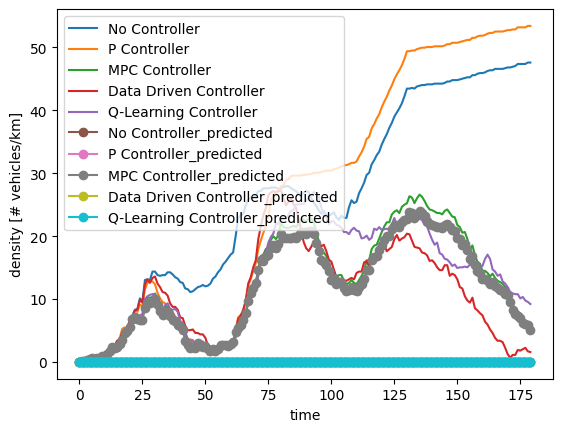

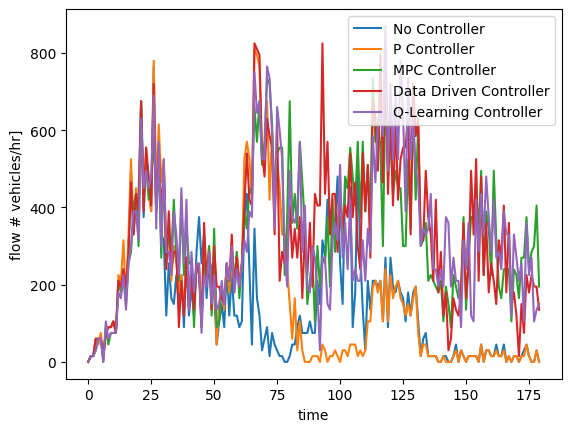

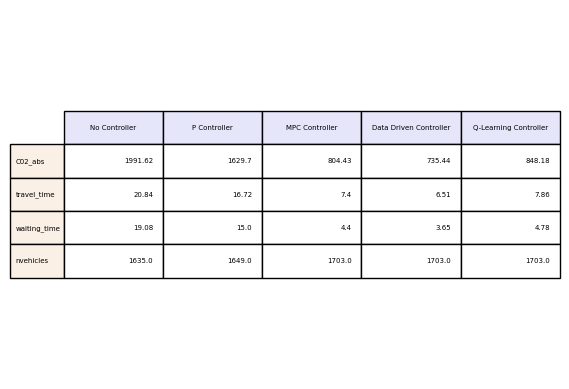

In [21]:
experiments = []
labels = []
experiments_nums = [0, 1, 2, 3, 4] # Specify the numbers of controller to compare
# 0 = No Controller
# 1 = P Controller
# 2 = MPC Controller
# 3 = Data-Driven Controller
# 4 = Q-Leaning Controller

# Every graph showed in the presentation slides is created changing the numbers of the controllers compared

if 0 in experiments_nums and experiment is not None:
    experiments.append(experiment)
    labels.append("No Controller")

if 1 in experiments_nums and p_experiment is not None:
    experiments.append(p_experiment)
    labels.append("P Controller")

if 2 in experiments_nums and mpc_experiment is not None:
    experiments.append(mpc_experiment)
    labels.append("MPC Controller")

if 3 in experiments_nums and data_driven_experiment is not None:
    experiments.append(data_driven_experiment)
    labels.append("Data Driven Controller")

if 4 in experiments_nums and q_learning_experiment is not None:
    experiments.append(q_learning_experiment)
    labels.append("Q-Learning Controller")


if experiments:
    region = 'Region 4'
    com = Comparison(experiments, labels, region=region)
    com.plot_density()
    com.plot_flow()
    com.plot_metrics()
    #com.plot()

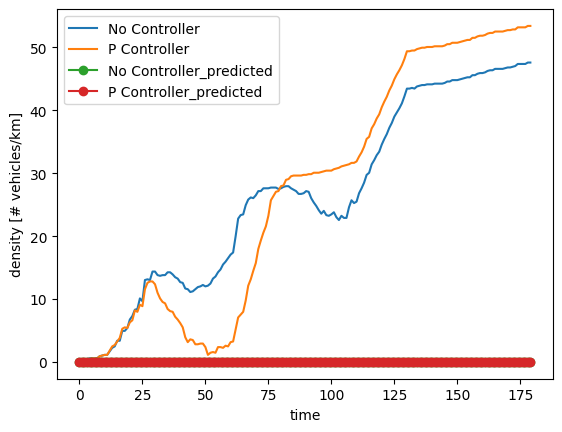

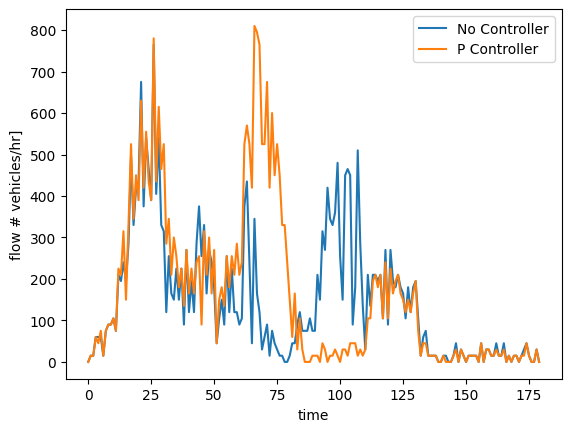

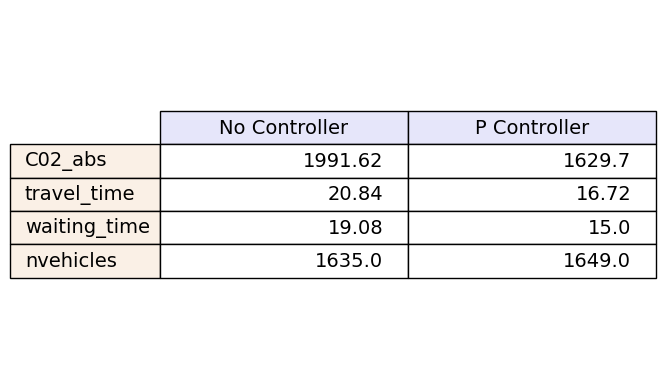

In [22]:
# No Controller compared to P Controller
experiments = []
labels = []
experiments_nums = [0, 1] # Specify the numbers of controller to compare
# 0 = No Controller
# 1 = P Controller
# 2 = MPC Controller
# 3 = Data-Driven Controller
# 4 = Q-Leaning Controller

if 0 in experiments_nums and experiment is not None:
    experiments.append(experiment)
    labels.append("No Controller")

if 1 in experiments_nums and p_experiment is not None:
    experiments.append(p_experiment)
    labels.append("P Controller")

if 2 in experiments_nums and mpc_experiment is not None:
    experiments.append(mpc_experiment)
    labels.append("MPC Controller")

if 3 in experiments_nums and data_driven_experiment is not None:
    experiments.append(data_driven_experiment)
    labels.append("Data Driven Controller")

if 4 in experiments_nums and q_learning_experiment is not None:
    experiments.append(q_learning_experiment)
    labels.append("Q-Learning Controller")


if experiments:
    region = 'Region 4'
    com = Comparison(experiments, labels, region=region)
    com.plot_density()
    com.plot_flow()
    com.plot_metrics()
    #com.plot()

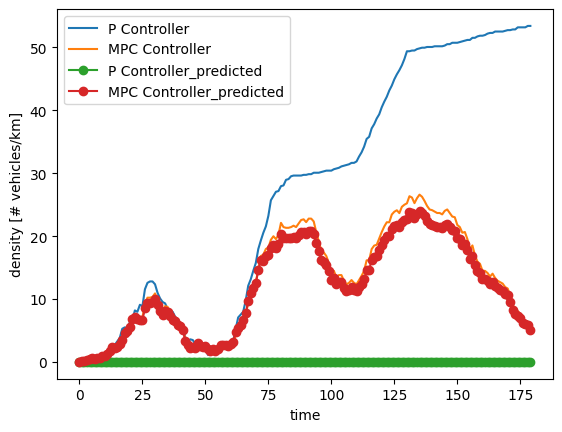

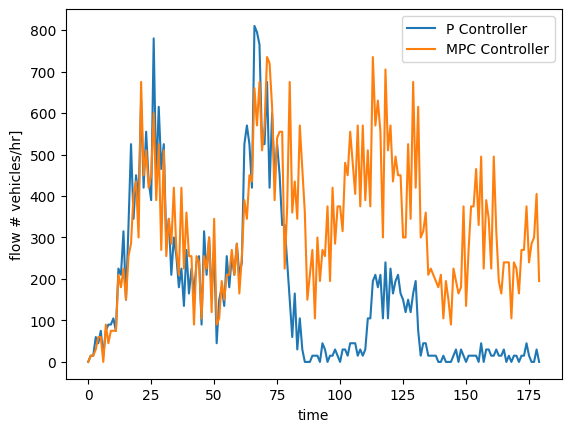

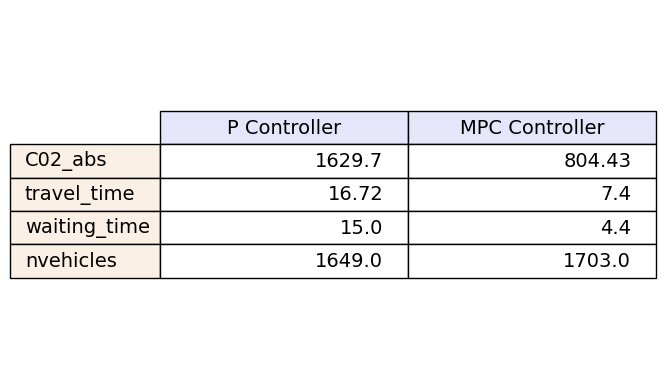

In [23]:
# P Controller compared to MPC Controller
experiments = []
labels = []
experiments_nums = [1, 2] # Specify the numbers of controller to compare
# 0 = No Controller
# 1 = P Controller
# 2 = MPC Controller
# 3 = Data-Driven Controller
# 4 = Q-Leaning Controller

if 0 in experiments_nums and experiment is not None:
    experiments.append(experiment)
    labels.append("No Controller")

if 1 in experiments_nums and p_experiment is not None:
    experiments.append(p_experiment)
    labels.append("P Controller")

if 2 in experiments_nums and mpc_experiment is not None:
    experiments.append(mpc_experiment)
    labels.append("MPC Controller")

if 3 in experiments_nums and data_driven_experiment is not None:
    experiments.append(data_driven_experiment)
    labels.append("Data Driven Controller")

if 4 in experiments_nums and q_learning_experiment is not None:
    experiments.append(q_learning_experiment)
    labels.append("Q-Learning Controller")


if experiments:
    region = 'Region 4'
    com = Comparison(experiments, labels, region=region)
    com.plot_density()
    com.plot_flow()
    com.plot_metrics()
    #com.plot()

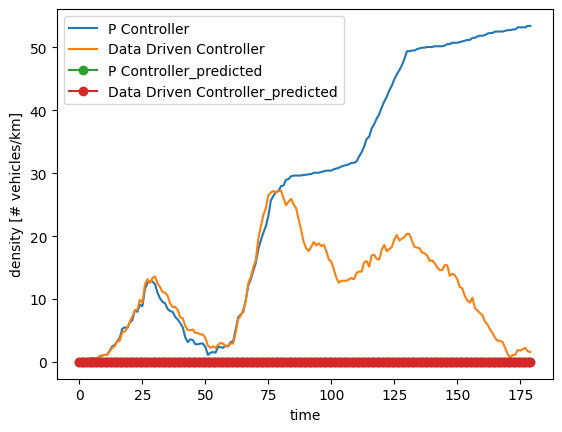

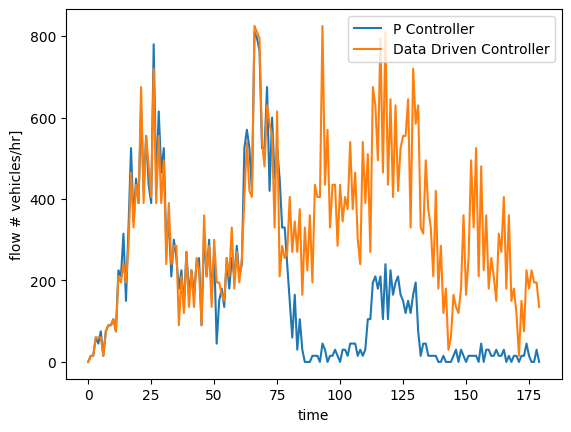

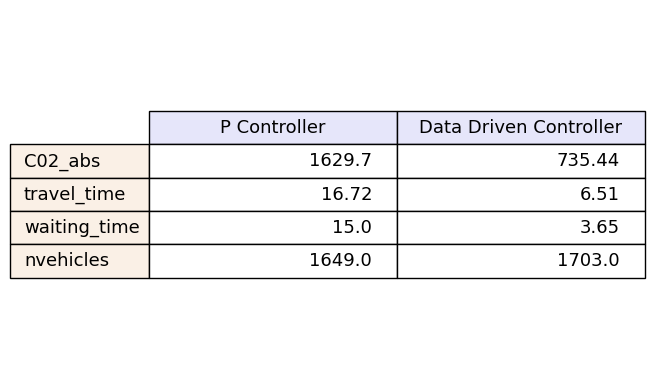

In [24]:
# P Controller compared to Data-Driven Controller
experiments = []
labels = []
experiments_nums = [1, 3] # Specify the numbers of controller to compare
# 0 = No Controller
# 1 = P Controller
# 2 = MPC Controller
# 3 = Data-Driven Controller
# 4 = Q-Leaning Controller

if 0 in experiments_nums and experiment is not None:
    experiments.append(experiment)
    labels.append("No Controller")

if 1 in experiments_nums and p_experiment is not None:
    experiments.append(p_experiment)
    labels.append("P Controller")

if 2 in experiments_nums and mpc_experiment is not None:
    experiments.append(mpc_experiment)
    labels.append("MPC Controller")

if 3 in experiments_nums and data_driven_experiment is not None:
    experiments.append(data_driven_experiment)
    labels.append("Data Driven Controller")

if 4 in experiments_nums and q_learning_experiment is not None:
    experiments.append(q_learning_experiment)
    labels.append("Q-Learning Controller")


if experiments:
    region = 'Region 4'
    com = Comparison(experiments, labels, region=region)
    com.plot_density()
    com.plot_flow()
    com.plot_metrics()
    #com.plot()

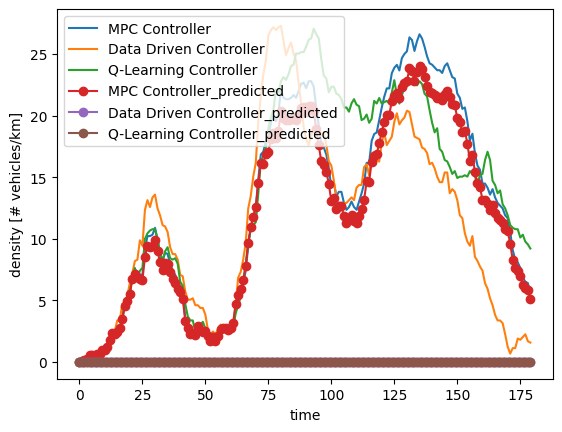

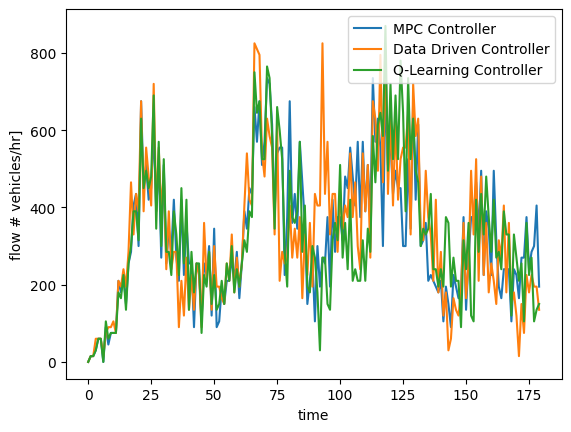

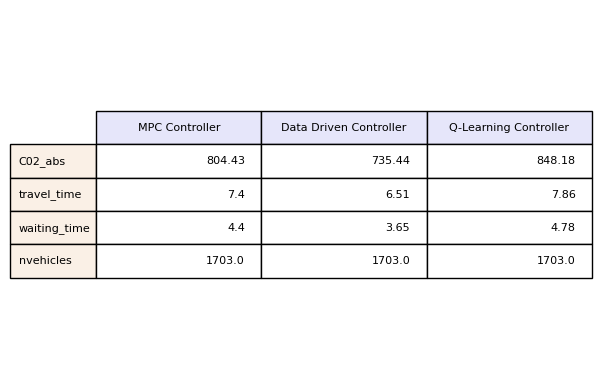

In [25]:
# Q-Learning Controller compared to MPC and Data-Driven Controllers
experiments = []
labels = []
experiments_nums = [2, 3, 4] # Specify the numbers of controller to compare
# 0 = No Controller
# 1 = P Controller
# 2 = MPC Controller
# 3 = Data-Driven Controller
# 4 = Q-Leaning Controller

if 0 in experiments_nums and experiment is not None:
    experiments.append(experiment)
    labels.append("No Controller")

if 1 in experiments_nums and p_experiment is not None:
    experiments.append(p_experiment)
    labels.append("P Controller")

if 2 in experiments_nums and mpc_experiment is not None:
    experiments.append(mpc_experiment)
    labels.append("MPC Controller")

if 3 in experiments_nums and data_driven_experiment is not None:
    experiments.append(data_driven_experiment)
    labels.append("Data Driven Controller")

if 4 in experiments_nums and q_learning_experiment is not None:
    experiments.append(q_learning_experiment)
    labels.append("Q-Learning Controller")


if experiments:
    region = 'Region 4'
    com = Comparison(experiments, labels, region=region)
    com.plot_density()
    com.plot_flow()
    com.plot_metrics()
    #com.plot()